# Load in SQLite database 

In [1]:
# Path to database file
db = "full_db_1000-february.sqlite3"
# Path to standard deviations JSON file
stdev_json = "standard_deviations.json"
# Path to dataset sizes csv
dataset_size_csv = "dataset_sizes.csv"

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore
import sqlite3
import json
from scipy.spatial import procrustes
from sklearn.metrics import mean_absolute_error as mae
from q2_mlab.db.schema import RegressionScore
from q2_mlab import ParameterGrids
from sqlalchemy import create_engine
from itertools import combinations, product
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
from tqdm.notebook import trange, tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/pmcgrath/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_repeats=1, random_state=None as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/pmcgrath/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_splits=3, n_repeats=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [ ]:
def connect():
    return sqlite3.connect(f"file:{db}?mode=ro", uri=True)
engine = create_engine("sqlite://", creator=connect)
data_raw = pd.read_sql_table(RegressionScore.__tablename__, con=engine)
df = process_db_df(data_raw)

In [2]:
algorithm_to_family = {
    'Lasso': "Linear",
    'RidgeRegressor': "Linear", 
    'LinearSVR': "Linear", 
    'ElasticNet': "Linear",
    'RandomForestRegressor': "Ensemble",
    'ExtraTreesRegressor': "Ensemble", 
    'XGBRegressor': "Boosting", 
    'LGBMRegressor_GBDT': "Boosting",
    'LGBMRegressor_RF': "Boosting",
    'GradientBoostingRegressor': "Boosting",
    'AdaBoostRegressor': "Boosting",
    "HistGradientBoostingRegressor": "Boosting",
    'MLPRegressor': "Other",
}

readablename = {
    'Lasso': "Lasso Regression",
    'RidgeRegressor': "Ridge Regression", 
    'LinearSVR': "Linear Support Vector", 
    'ElasticNet': "Logistic Regression with Elastic Net",
    'RandomForestRegressor': "Random Forest",
    'ExtraTreesRegressor': "Extremely Randomized Trees", 
    'XGBRegressor': "XGBoost", 
    'LGBMRegressor_GBDT': "LightGBM with Gradient Boosted Trees",
    'LGBMRegressor_RF': "LightGBM with Random Forest",
    'GradientBoostingRegressor': "Gradient Boosted Trees",
    "HistGradientBoostingRegressor": "Histogram Gradient Boosting",
    'AdaBoostRegressor': "AdaBoost",
    'MLPRegressor': "Multilayer Perceptron",
}

def order_by_counts(data, column):
    counts = data[column].value_counts()
    return list(counts.index), list(counts.values)

def order_by_paramspace_size(data):
    algorithms = data["algorithm"].unique()
    sizes = [(ParameterGrids.get_size(a),a) for a in algorithms]
    sizes = sorted(sizes)[::-1]
    ordering, values = (
        [a[1] for a in sizes], [a[0] for a in sizes]
    )
    return ordering, values

def order_by_paramspace_cardinality(data):
    algorithms = data["algorithm"].unique()
    sizes = []
    for a in algorithms:
        if a == "RidgeRegressor":
            sizes.append((len(ParameterGrids.get(a)[0]), a))
        else:
            sizes.append((len(ParameterGrids.get(a)),a))
        
    sizes = sorted(sizes)[::-1]
    ordering, values = (
        [a[1] for a in sizes], [a[0] for a in sizes]
    )
    return ordering, values

In [3]:
# port over the database transformations from plotting code
groups = ['parameters_id', 'dataset', 'target', 'level', 'algorithm']
drop_cols = ['artifact_uuid', 'datetime', 'CV_IDX', 'id']

target_map = {
    'age_v2': 'age',
    'BL_AGE': 'age',
    'age': 'age',
    'bmi_v2': 'bmi',
    'BMI': 'bmi',
    'bmi': 'bmi'
}

with open(stdev_json) as f:
    TARGET_SD = json.load(f)

def _get_standardized_mae(df_row, norm_dict):
    """
    """
    mae = df_row['MAE']
    target = df_row['target']
    dataset = df_row['dataset']
    cv_fold = df_row['CV_IDX']
    level = df_row['level']
    key = f"({dataset}, {target}, {level}, {cv_fold})"
    sd = norm_dict.get(key, 1)
    standardized_mae = mae / sd
    return standardized_mae

def process_db_df(df):
    # remap values for consistency
    df['level'] = df['level'].replace('none', 'MG')
    df['target'] = df['target'].map(target_map)
    df['standardized_MAE'] = df.apply(_get_standardized_mae, axis=1,
                                      args=(TARGET_SD,))

    group_stats = df.drop(
        drop_cols, axis=1
    ).groupby(
        groups
    ).agg(
        ['var', 'mean']
    )

    group_stats.columns = agg_columns = ['_'.join(col).strip() for
                                         col in group_stats.columns.values]

    group_stats.reset_index(inplace=True)

    min_by = ['dataset', 'target']
    group_mins = group_stats[agg_columns + min_by].groupby(min_by).min()
    indices = group_stats[['dataset', 'target']].to_records(
        index=False).tolist()
    expanded_group_mins = group_mins.loc[indices]
    expanded_group_mins.index = group_stats.index
    relative_group_stats = (group_stats / expanded_group_mins)[agg_columns]
    relative_group_stats.columns = ['relative_' + col for
                                    col in relative_group_stats]
    group_stats = group_stats.join(relative_group_stats)

    return group_stats

In [5]:
df.algorithm.unique()

array(['Lasso', 'RidgeRegressor', 'LinearSVR', 'RandomForestRegressor',
       'ExtraTreesRegressor', 'XGBRegressor', 'LGBMRegressor_GBDT',
       'LGBMRegressor_RF', 'GradientBoostingRegressor',
       'AdaBoostRegressor', 'ElasticNet', 'MLPRegressor'], dtype=object)

[Figure 1](#FIG1)
[Figure 2](#FIG2)

## Procrustes 
1. Select a pair of datasets
2. Filter to intersection of target, algorithm, level, and parameters id between datasets
3. Ensure datasets have same number of rows
4. Split the data into pairs of standardized_MAE_MEAN vs standardized_MAE_VAR

In [69]:
dataset_a = []
dataset_b = []
targets = []
levels = []
algorithms = []
disparities = []
for a, b in combinations(df["dataset"].unique(), 2):
    for target in df["target"].unique():
        for level in df["level"].unique():
            # print(a,b,target,level)
            # Filter to intersection across parameters id
            for algorithm in df["algorithm"].unique():
                a_query = df.query(f"dataset == '{a}' & target == '{target}' & level == '{level}' & algorithm == '{algorithm}'")
                b_query = df.query(f"dataset == '{b}' & target == '{target}' & level == '{level}' & algorithm == '{algorithm}'")
                
                # ignore if either of these has no results
                if a_query.shape[0]==0 or b_query.shape[0]==0:
                    continue
                
                a_query.set_index("parameters_id", inplace=True)
                b_query.set_index("parameters_id", inplace=True)
                
                # Filter nans and inf from columns in procrustes matrix
                matrix_cols = ["standardized_MAE_mean", "standardized_MAE_var"]
                a_query = a_query.replace([np.inf, -np.inf], np.nan)
                b_query = b_query.replace([np.inf, -np.inf], np.nan)
                a_query = a_query.dropna(axis="index", how="any", subset=matrix_cols)
                b_query = b_query.dropna(axis="index", how="any", subset=matrix_cols)
                
                # Filter to the same subset of parameter ids
                shared_params = list(set(a_query.index).intersection(b_query.index))
                a_filtered = a_query.loc[shared_params]
                b_filtered = b_query.loc[shared_params]
                # print(len(shared_params), a_filtered.shape, b_filtered.shape)
                
                # Get matrices of same size
                a_matrix = a_filtered[matrix_cols].to_numpy()
                b_matrix = b_filtered[matrix_cols].to_numpy()
                
                # procrustes!
                try:
                    mtx1, mtx2, disparity = procrustes(a_matrix, b_matrix)
                except:
                    print(a_matrix)
                    print(b_matrix)
                    raise e
                
                dataset_a.append(a)
                dataset_b.append(b)
                targets.append(target)
                levels.append(level)
                algorithms.append(algorithm)
                disparities.append(disparity)

results = pd.DataFrame()
results["dataset_a"] = dataset_a
results["dataset_b"] = dataset_b
results["dataset_pair"] = list(zip(dataset_a, dataset_b))
results["target"] = targets
results["level"] = levels
results["algorithm"] = algorithms
results["disparity"] = disparities
between_dataset_results = results.query(
    "algorithm not in ['AdaBoostRegressor', 'MLPRegressor', 'ExtraTreesRegressor', 'Lasso', 'GradientBoostingRegressor']"
)
between_dataset_results

,dataset_a,dataset_b,dataset_pair,target,level,algorithm,disparity
0,finrisk,imsms,"(finrisk, imsms)",age,16S,RidgeRegressor,0.905438
1,finrisk,imsms,"(finrisk, imsms)",age,16S,LinearSVR,0.574923
2,finrisk,imsms,"(finrisk, imsms)",age,16S,RandomForestRegressor,0.308241
3,finrisk,imsms,"(finrisk, imsms)",age,16S,XGBRegressor,0.453923
4,finrisk,imsms,"(finrisk, imsms)",age,16S,LGBMRegressor_GBDT,0.110338
...,...,...,...,...,...,...,...
122,imsms,sol,"(imsms, sol)",bmi,MG,XGBRegressor,0.000034
123,imsms,sol,"(imsms, sol)",bmi,MG,LGBMRegressor_GBDT,0.075565
124,imsms,sol,"(imsms, sol)",bmi,MG,LGBMRegressor_RF,0.075565
127,imsms,sol,"(imsms, sol)",bmi,MG,ElasticNet,0.393709


In [70]:
idx_to_drop = []
for a, b in combinations(df["dataset"].unique(), 2):
    for level in df["level"].unique():
        bmi_results = between_dataset_results.query(
f"dataset_a=='{a}' and dataset_b=='{b}' and target=='bmi' and level=='{level}'"
        )
        age_results = between_dataset_results.query(
f"dataset_a=='{a}' and dataset_b=='{b}' and target=='age' and level=='{level}'"
        )
        
        diff = set(bmi_results.algorithm.values).symmetric_difference(
            set(age_results.algorithm.values)
        )
        
        for alg in diff:
            idx_to_drop.extend(bmi_results.query(f"algorithm=='{alg}'").index.values)
            idx_to_drop.extend(age_results.query(f"algorithm=='{alg}'").index.values)
print(between_dataset_results.shape)
between_dataset_results = between_dataset_results.drop(idx_to_drop, axis=0)
print(between_dataset_results.shape)

(90, 7)
(84, 7)


In [77]:
def get_box_pairs(data, a, b):
    unique_labels = data[a].unique()
    unique_sampletypes = data[b].unique()
    box_pairs = []
    for sampletype in unique_sampletypes:
        inner_pairs = list(combinations(unique_labels, 2))
        for pair in inner_pairs:
            double_pair = ((sampletype, pair[0]), (sampletype, pair[1]))
            box_pairs.append(double_pair)
    return box_pairs

def procrust_boxplot(results, x, hue, palette, title):
    # plot average dispersion by algorithm
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title

    fig, ax = plt.subplots()
    sns.boxplot(
        x=x,
        y="disparity",
        hue=hue,
        data=results,
        linewidth=2.5,
        ax=ax,
        palette=palette
    )
    markers = {
        "Lasso" : '.',
        "RidgeRegressor" : '.',
        "LinearSVR" : '.',
        "ElasticNet" : '.',
        "MLPRegressor" : '.',
        "RandomForestRegressor" : '^',
        "ExtraTreesRegressor" : '^',
        "XGBRegressor" : 's',
        "LGBMRegressor_GBDT" : 's',
        "LGBMRegressor_RF" : 's',
        "GradientBoostingRegressor" : 's',
        "AdaBoostRegressor" : 's',
    }
    sns.swarmplot(
        x=x,
        y="disparity",
        hue=hue,
        data=results,
        linewidth=2.5,
        ax=ax,
        palette=palette,
        dodge=True,
        # markers=markers,
    )
    box_pairs = get_box_pairs(results, hue, x)
    add_stat_annotation(
        ax,
        x=x,
        hue=hue,
        plot='barplot',
        data=results, 
        y="disparity",
        box_pairs=box_pairs,
        test='t-test_paired',
        text_format='star', 
        loc='inside',
        verbose=0, #verbose=2,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation = 75)
    fig.suptitle(title)
    fig.set_size_inches(6, 6)

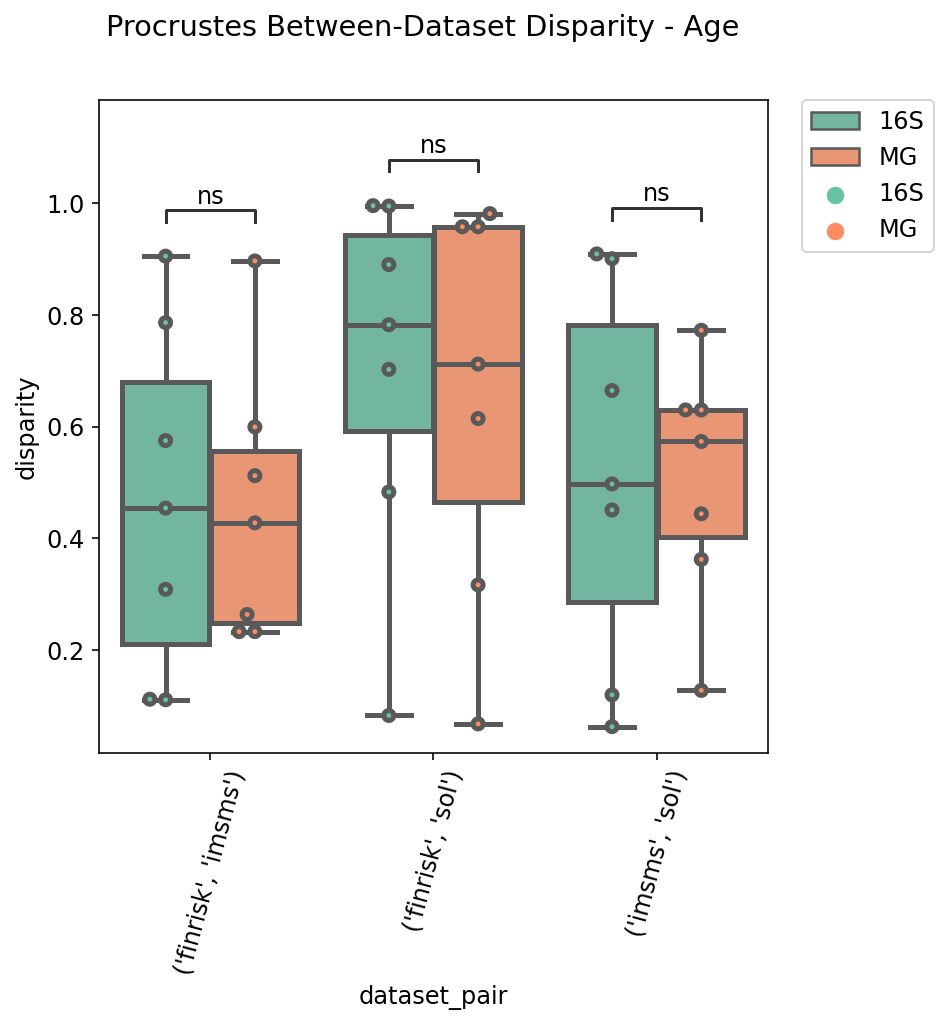

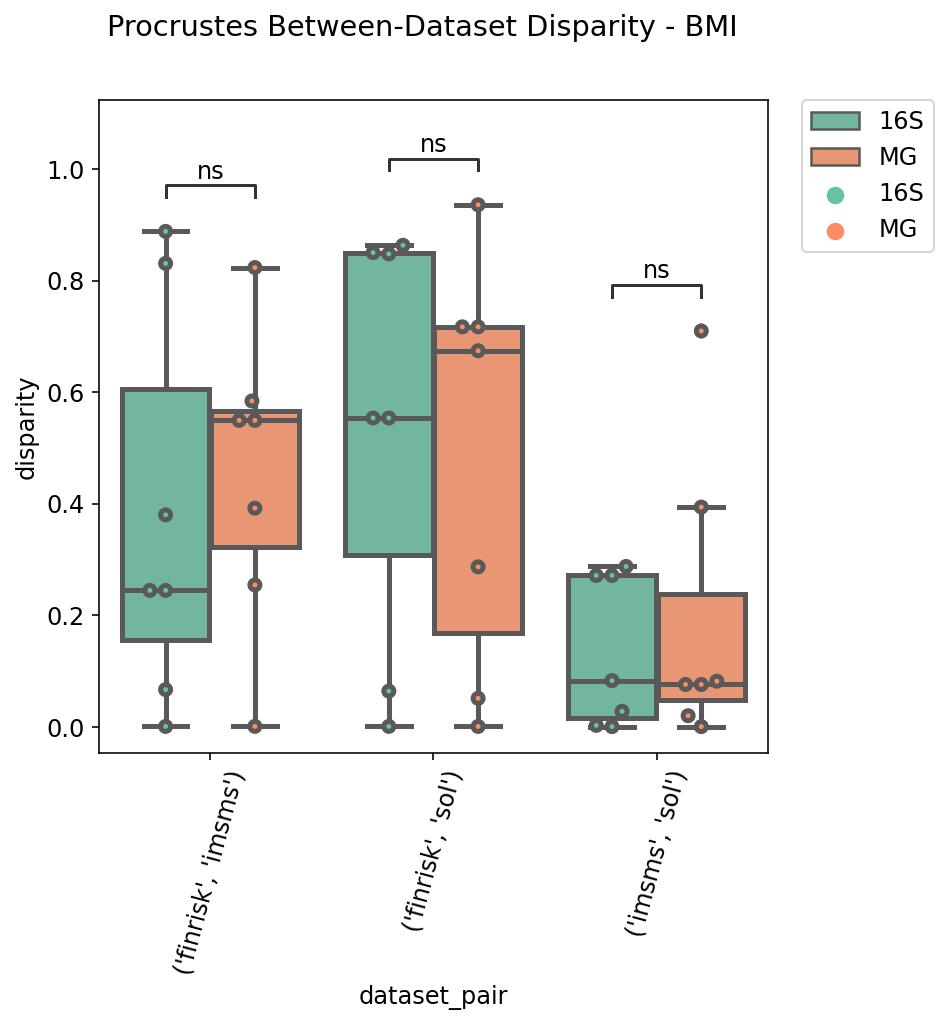

In [78]:
procrust_boxplot(between_dataset_results.query("target=='age'"), 
                 x="dataset_pair", hue="level", palette="Set2", 
                 title="Procrustes Between-Dataset Disparity - Age")
procrust_boxplot(between_dataset_results.query("target=='bmi'"),
                 x="dataset_pair", hue="level", palette="Set2", 
                 title="Procrustes Between-Dataset Disparity - BMI")

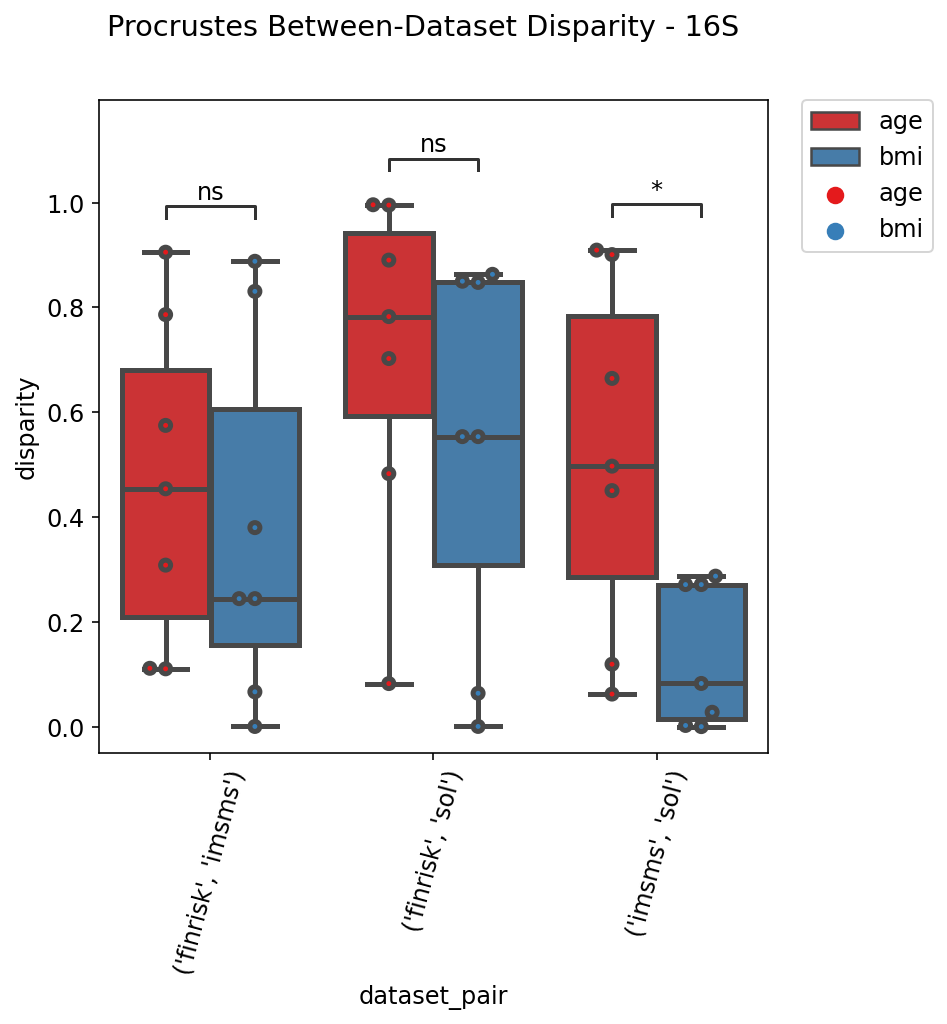

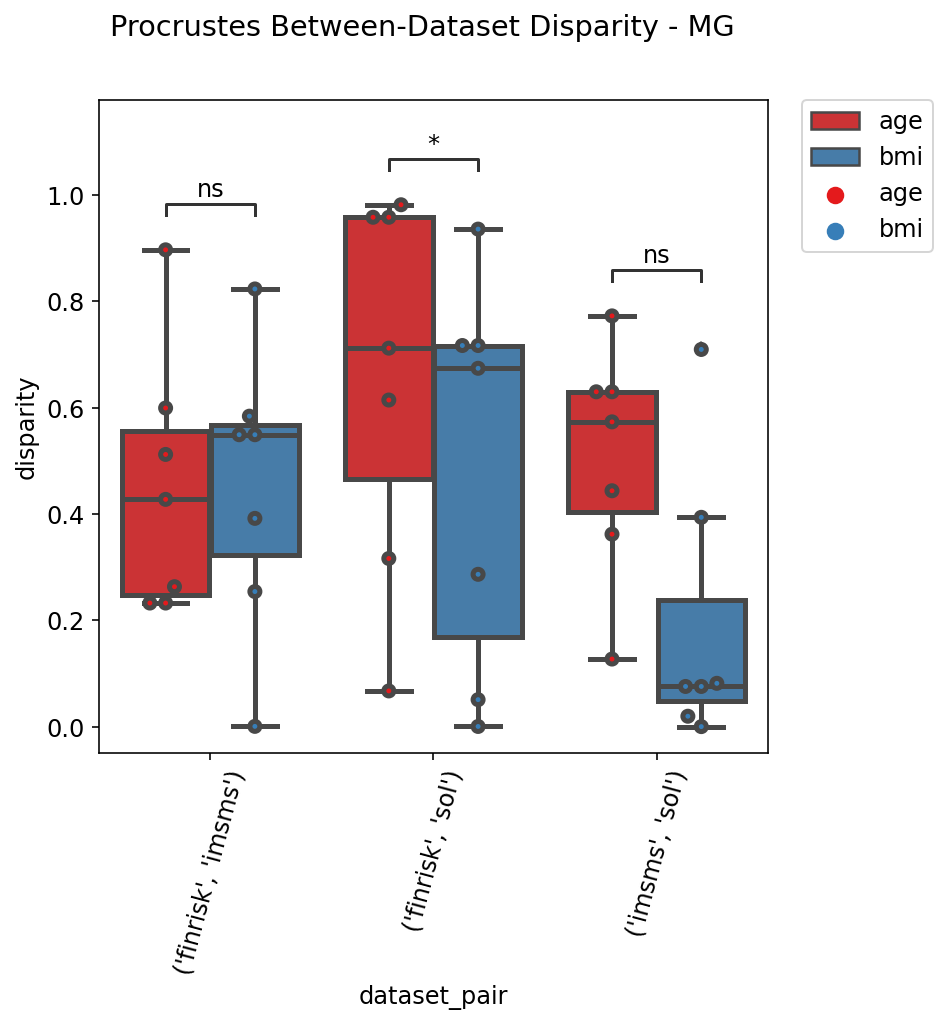

In [79]:
procrust_boxplot(between_dataset_results.query("level=='16S'"), 
                 x="dataset_pair", hue="target", palette="Set1", 
                 title="Procrustes Between-Dataset Disparity - 16S")
procrust_boxplot(between_dataset_results.query("level=='MG'"),
                 x="dataset_pair", hue="target", palette="Set1", 
                 title="Procrustes Between-Dataset Disparity - MG")

/Users/pmcgrath/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/Users/pmcgrath/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/scipy/stats/stats.py:7028: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


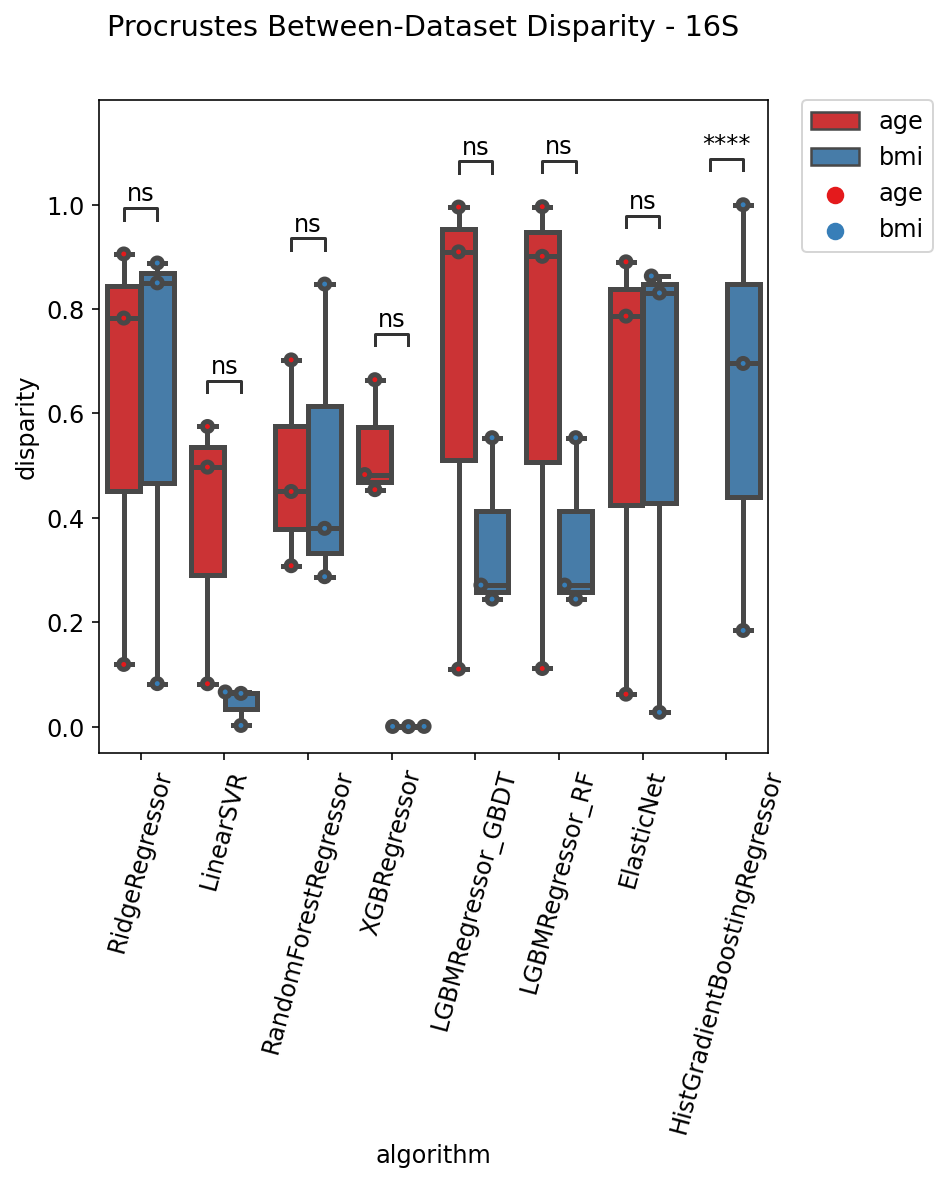

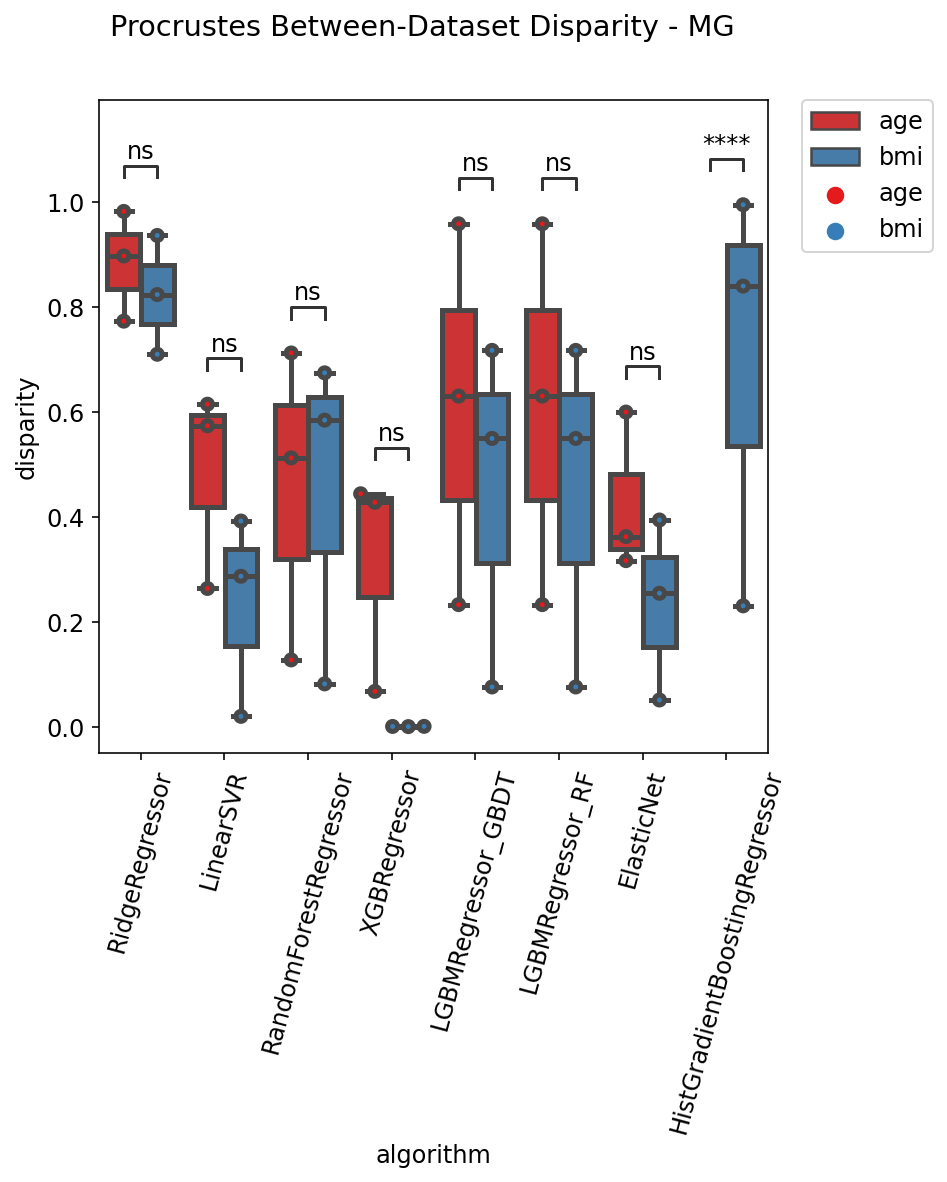

In [10]:
procrust_boxplot(between_dataset_results.query("level=='16S'"), 
                 x="algorithm", hue="target", palette="Set1", 
                 title="Procrustes Between-Dataset Disparity - 16S")
procrust_boxplot(between_dataset_results.query("level=='MG'"),
                 x="algorithm", hue="target", palette="Set1", 
                 title="Procrustes Between-Dataset Disparity - MG")

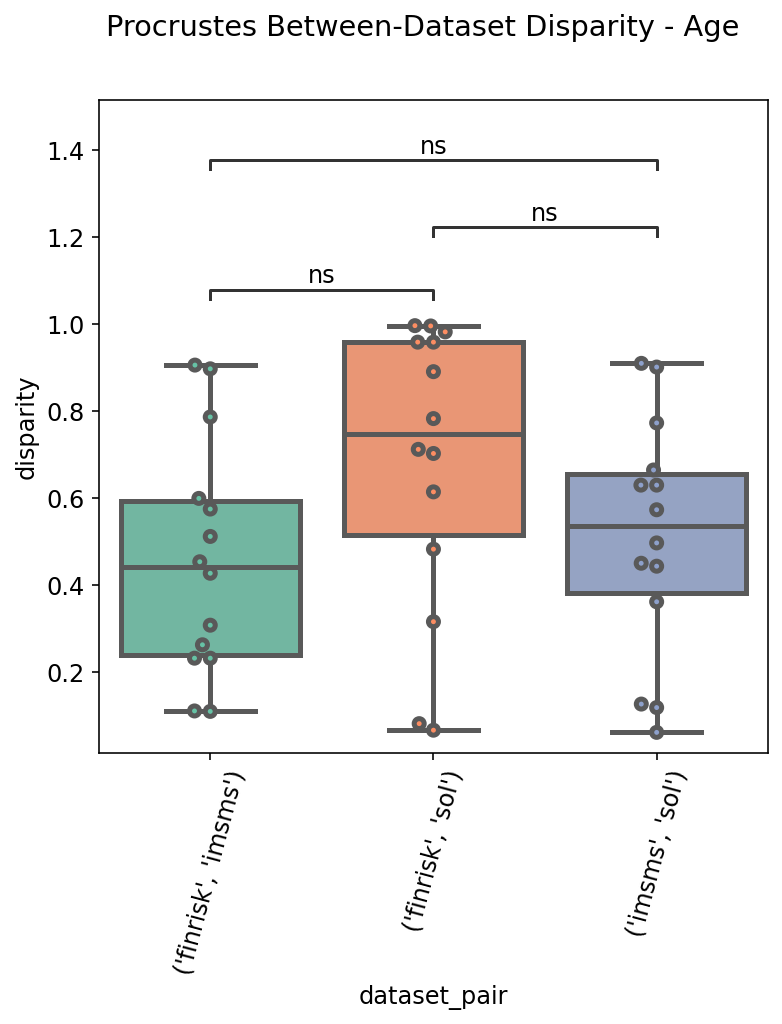

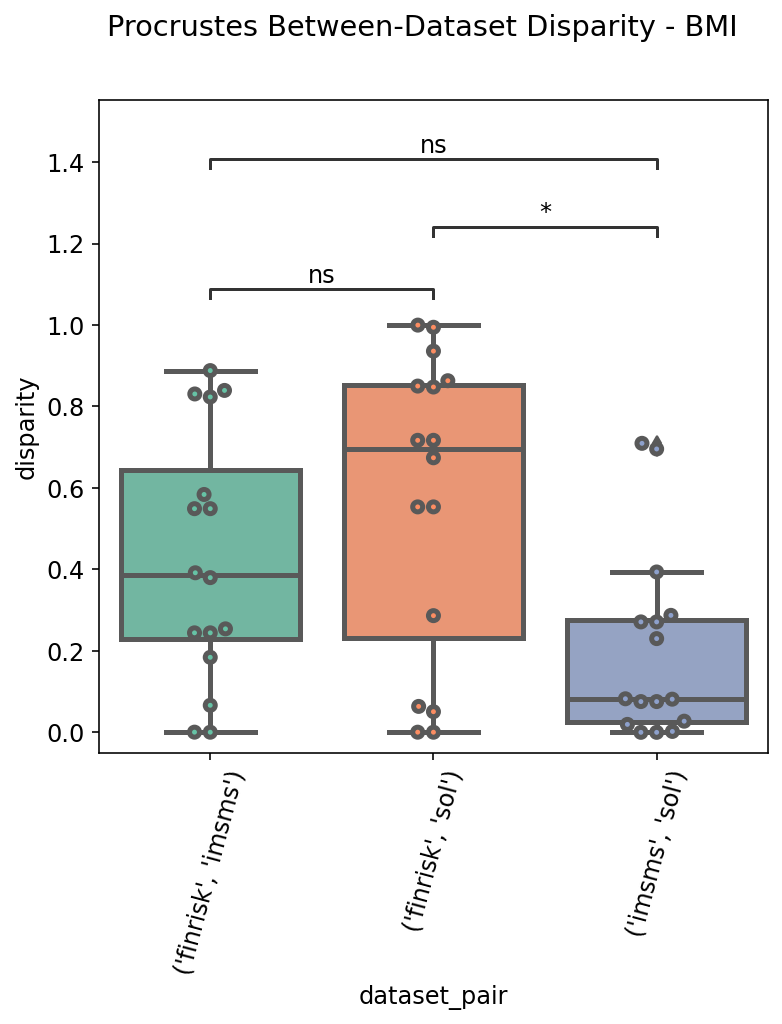

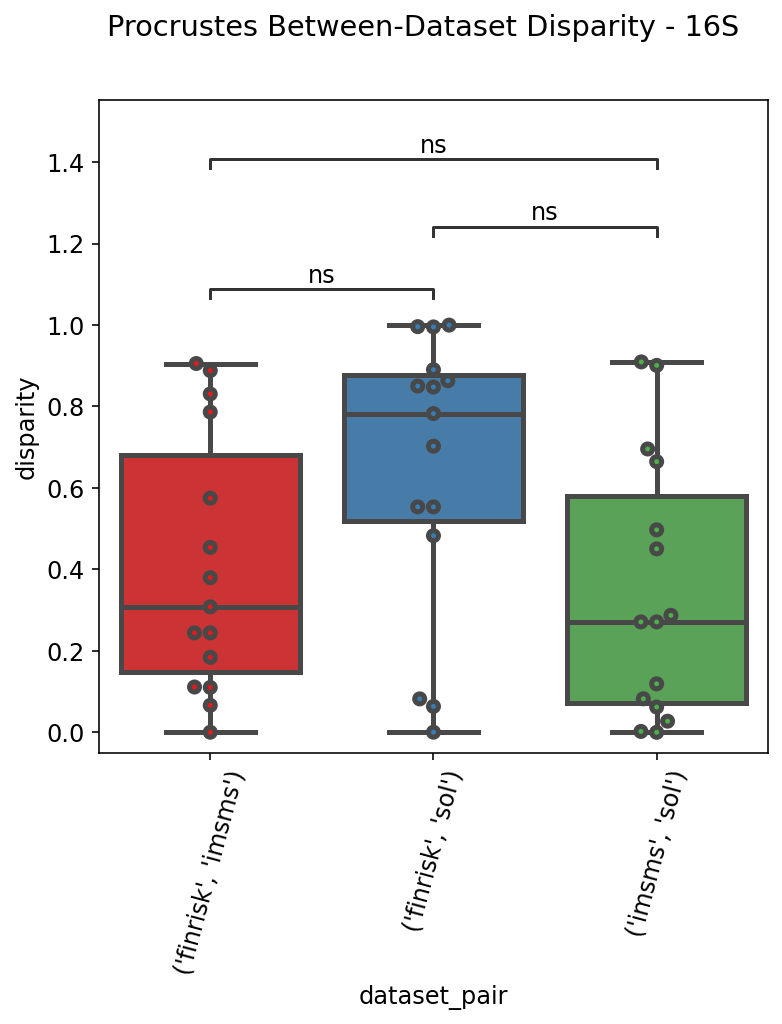

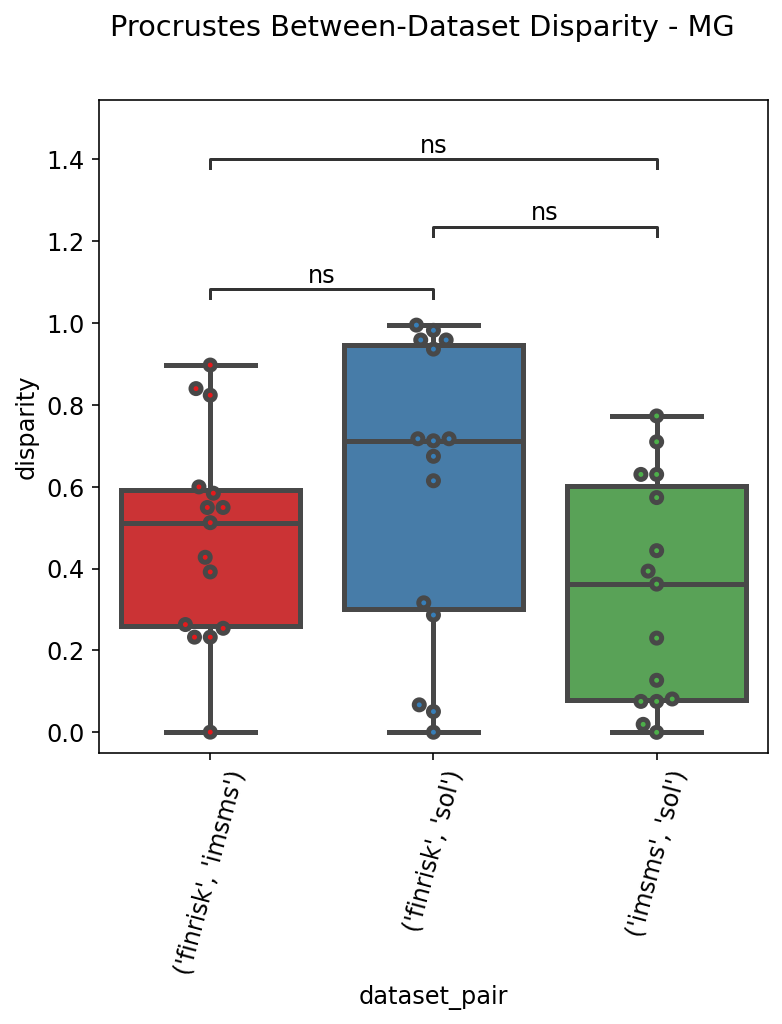

In [11]:
def get_box_pairs(data, a, b=None):
    unique_labels = data[a].unique()
    box_pairs = []
    
    if a and b:
        unique_sampletypes = data[b].unique()
        for sampletype in unique_sampletypes:
            inner_pairs = list(combinations(unique_labels, 2))
            for pair in inner_pairs:
                double_pair = ((sampletype, pair[0]), (sampletype, pair[1]))
                box_pairs.append(double_pair)
    if not b:
        box_pairs = list(combinations(unique_labels, 2))
    return box_pairs

def procrust_boxplot2(results, x, hue, palette, title):
    # plot average dispersion by algorithm
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title

    fig, ax = plt.subplots()
    sns.boxplot(
        x=x,
        y="disparity",
        data=results,
        linewidth=2.5,
        ax=ax,
        palette=palette
    )
    sns.swarmplot(
        x=x,
        y="disparity",
        data=results,
        linewidth=2.5,
        ax=ax,
        palette=palette,
        dodge=True,
    )
    box_pairs = get_box_pairs(results, x)
    add_stat_annotation(
        ax,
        x=x,
        plot='barplot',
        data=results, 
        y="disparity",
        box_pairs=box_pairs,
        test='Mann-Whitney',
        text_format='star', 
        loc='inside',
        verbose=0, #verbose=2,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation = 75)
    fig.suptitle(title)
    fig.set_size_inches(6, 6)
    
procrust_boxplot2(between_dataset_results.query("target=='age'"), 
                 x="dataset_pair", hue="level", palette="Set2", 
                 title="Procrustes Between-Dataset Disparity - Age")
procrust_boxplot2(between_dataset_results.query("target=='bmi'"),
                 x="dataset_pair", hue="level", palette="Set2", 
                 title="Procrustes Between-Dataset Disparity - BMI")
procrust_boxplot2(between_dataset_results.query("level=='16S'"), 
                 x="dataset_pair", hue="target", palette="Set1", 
                 title="Procrustes Between-Dataset Disparity - 16S")
procrust_boxplot2(between_dataset_results.query("level=='MG'"),
                 x="dataset_pair", hue="target", palette="Set1", 
                 title="Procrustes Between-Dataset Disparity - MG")

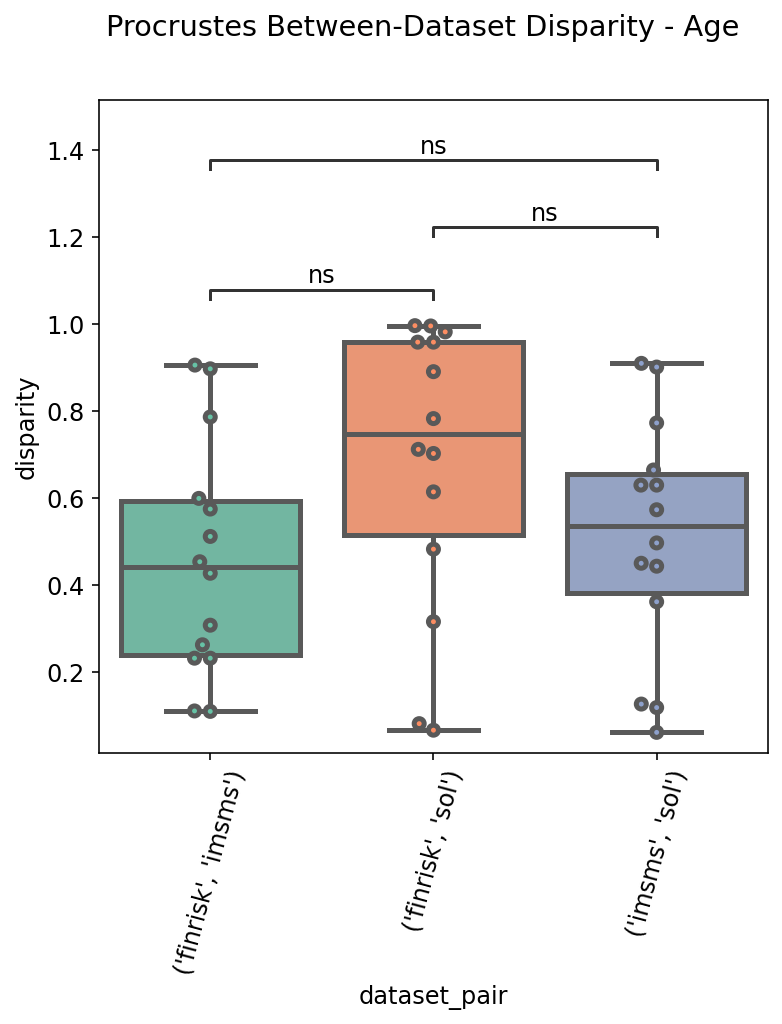

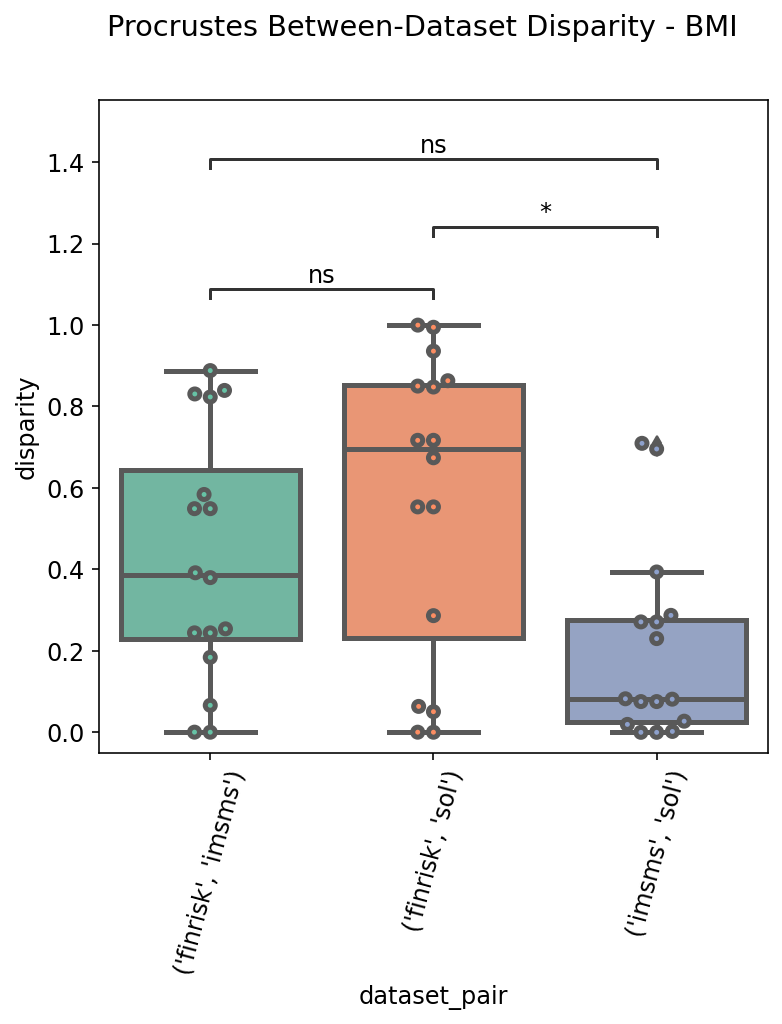

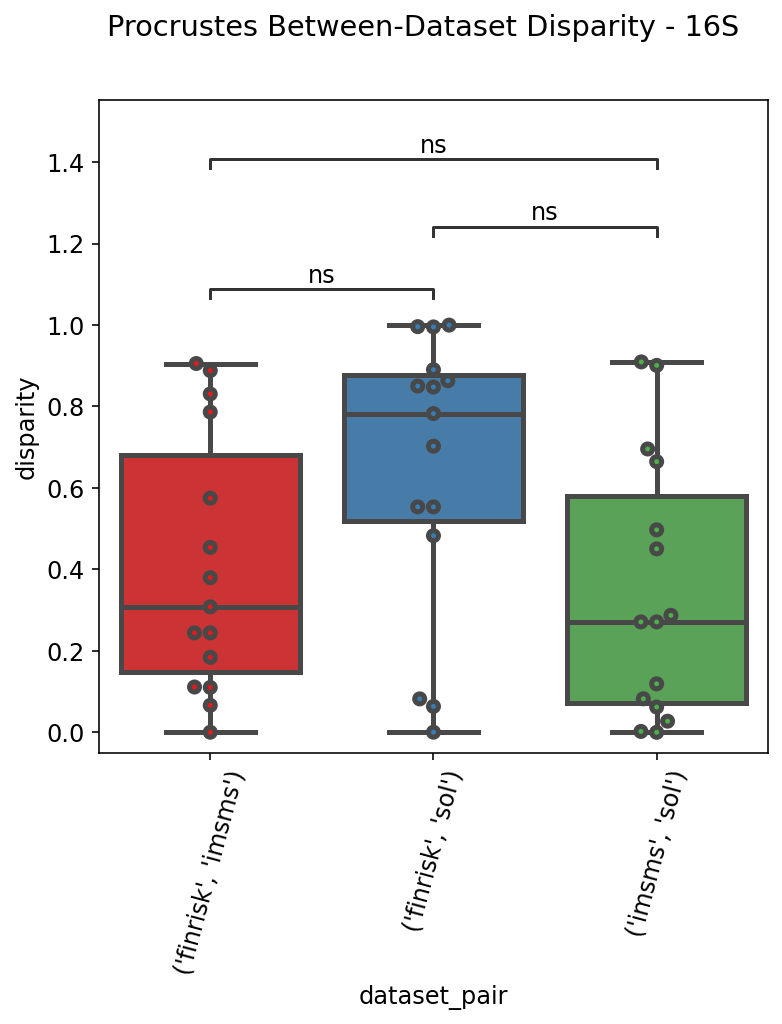

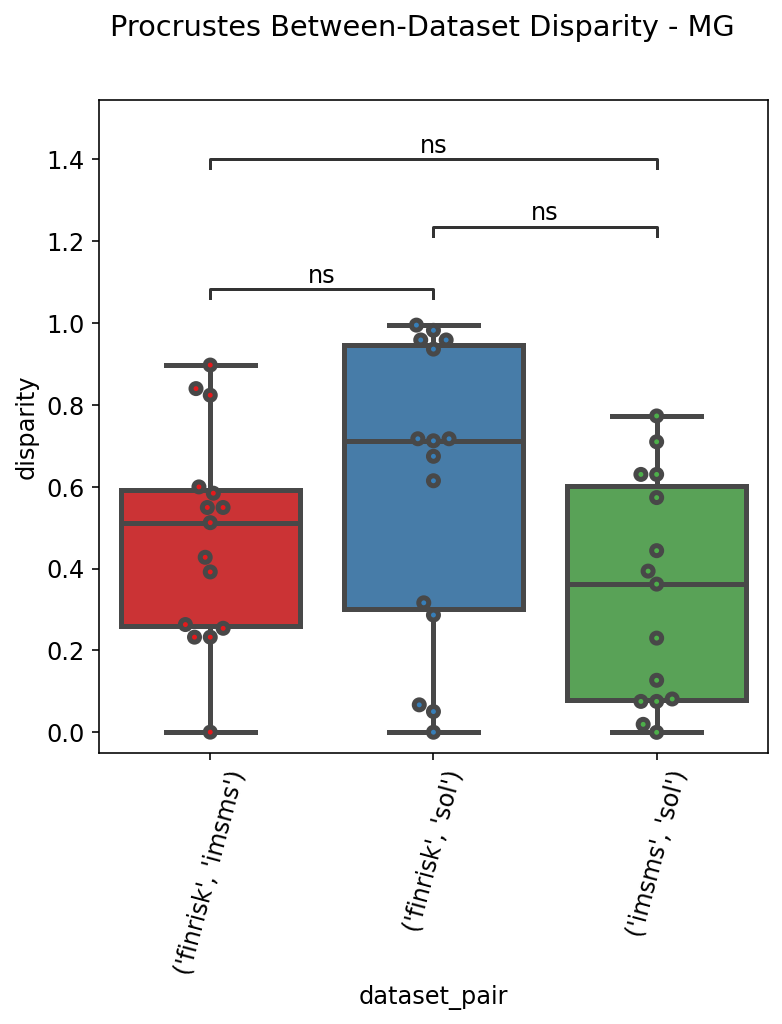

In [12]:
def get_box_pairs(data, a, b=None):
    unique_labels = data[a].unique()
    box_pairs = []
    
    if a and b:
        unique_sampletypes = data[b].unique()
        for sampletype in unique_sampletypes:
            inner_pairs = list(combinations(unique_labels, 2))
            for pair in inner_pairs:
                double_pair = ((sampletype, pair[0]), (sampletype, pair[1]))
                box_pairs.append(double_pair)
    if not b:
        box_pairs = list(combinations(unique_labels, 2))
    return box_pairs

def procrust_boxplot2(results, x, hue, palette, title):
    # plot average dispersion by algorithm
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title

    fig, ax = plt.subplots()
    sns.boxplot(
        x=x,
        y="disparity",
        data=results,
        linewidth=2.5,
        ax=ax,
        palette=palette
    )
    sns.swarmplot(
        x=x,
        y="disparity",
        data=results,
        linewidth=2.5,
        ax=ax,
        palette=palette,
        dodge=True,
    )
    box_pairs = get_box_pairs(results, x)
    add_stat_annotation(
        ax,
        x=x,
        plot='barplot',
        data=results, 
        y="disparity",
        box_pairs=box_pairs,
        test='Mann-Whitney',
        text_format='star', 
        loc='inside',
        verbose=0, #verbose=2,
    )
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation = 75)
    fig.suptitle(title)
    fig.set_size_inches(6, 6)
    
procrust_boxplot2(between_dataset_results.query("target=='age'"), 
                 x="dataset_pair", hue="level", palette="Set2", 
                 title="Procrustes Between-Dataset Disparity - Age")
procrust_boxplot2(between_dataset_results.query("target=='bmi'"),
                 x="dataset_pair", hue="level", palette="Set2", 
                 title="Procrustes Between-Dataset Disparity - BMI")
procrust_boxplot2(between_dataset_results.query("level=='16S'"), 
                 x="dataset_pair", hue="target", palette="Set1", 
                 title="Procrustes Between-Dataset Disparity - 16S")
procrust_boxplot2(between_dataset_results.query("level=='MG'"),
                 x="dataset_pair", hue="target", palette="Set1", 
                 title="Procrustes Between-Dataset Disparity - MG")

### get global disparity using standardized metrics


0.0


/Users/pmcgrath/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


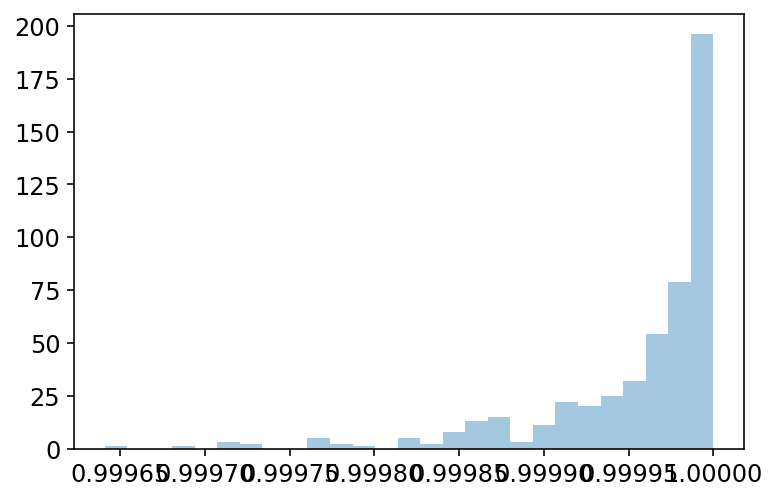

In [13]:
def get_null_disparities(a_matrix, b_matrix, n_repeats):
    
    a_null_matrix = np.copy(a_matrix)
    b_null_matrix = np.copy(b_matrix)
    
    null_disparities = []
    np.random.seed = 2021
    rng = np.random.default_rng()
    for i in trange(n_repeats):
        # shuffle row order
        rng.shuffle(a_null_matrix, axis=0)
        rng.shuffle(b_null_matrix, axis=0)
        
        _, _, null_disparity = procrustes(a_null_matrix, b_null_matrix)
        null_disparities.append(null_disparity)
    
    return null_disparities, np.mean(null_disparities)

size = 50000
test_a = np.array(range(size)).reshape(int(size/2),2)
test_b = np.array(range(size)).reshape(int(size/2),2)

null_distribution, mean_null = get_null_disparities(test_a, test_b, n_repeats=500)
_, _, disparity = procrustes(test_a, test_b)

print(percentileofscore(null_distribution, disparity))
sns.distplot(null_distribution, kde=False)

(1000, 2) (1000, 2)


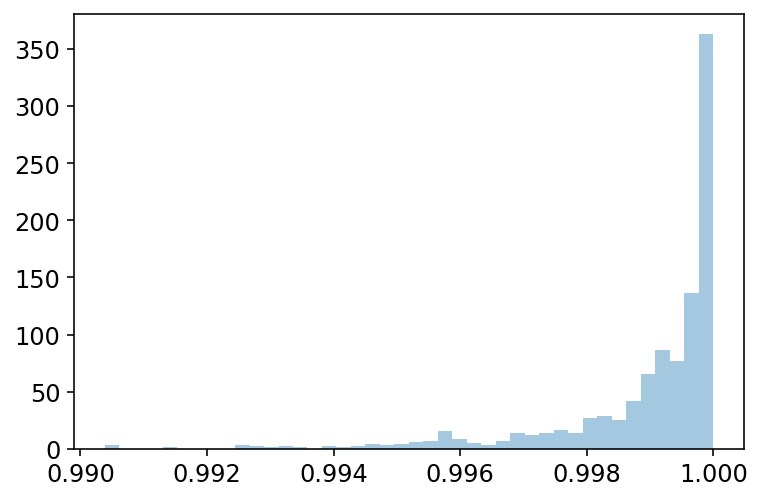

In [14]:
print(a_matrix.shape, b_matrix.shape)
null_distribution, mean_null = get_null_disparities(a_matrix, b_matrix, n_repeats=1000)
sns.distplot(null_distribution, kde=False)

In [15]:
dataset_a = []
dataset_b = []
targets = []
levels = []
algorithms = []
disparities = []
null_disparities = []
percentiles = []
for a, b in combinations(df["dataset"].unique(), 2):
    all_a = []
    all_b = []
    for target in df["target"].unique():
        for level in df["level"].unique():
            # print(a,b,target,level)
            # Filter to intersection across parameters id
            for algorithm in df["algorithm"].unique():
                a_query = df.query(f"dataset == '{a}' & target == '{target}' & level == '{level}' & algorithm == '{algorithm}'")
                b_query = df.query(f"dataset == '{b}' & target == '{target}' & level == '{level}' & algorithm == '{algorithm}'")
                
                # ignore if either of these has no results
                if a_query.shape[0]==0 or b_query.shape[0]==0:
                    continue
                
                
                a_query.set_index("parameters_id", inplace=True)
                b_query.set_index("parameters_id", inplace=True)
                
                # Filter nans and inf from columns in procrustes matrix
                matrix_cols = ["standardized_MAE_mean", "standardized_MAE_var"]
                a_query = a_query.replace([np.inf, -np.inf], np.nan)
                b_query = b_query.replace([np.inf, -np.inf], np.nan)
                a_query = a_query.dropna(axis="index", how="any", subset=matrix_cols)
                b_query = b_query.dropna(axis="index", how="any", subset=matrix_cols)
                
                # Filter to the same subset of parameter ids
                shared_params = list(set(a_query.index).intersection(b_query.index))
                a_filtered = a_query.loc[shared_params]
                b_filtered = b_query.loc[shared_params]
                # print(len(shared_params), a_filtered.shape, b_filtered.shape)
                
                all_a.append(a_filtered)
                all_b.append(b_filtered)
                
    a_filtered = pd.concat(all_a)
    b_filtered = pd.concat(all_b)
    # Get matrices of same size
    a_matrix = a_filtered[["standardized_MAE_mean", "standardized_MAE_var"]].to_numpy()
    b_matrix = b_filtered[["standardized_MAE_mean", "standardized_MAE_var"]].to_numpy()
    
    # procrustes!
    _, _, disparity = procrustes(a_matrix, b_matrix)
    # Get null dist and mean null disparity
    null_distribution, null_disparity = get_null_disparities(
        a_matrix, b_matrix, n_repeats=500
    )

    dataset_a.append(a)
    dataset_b.append(b)
    disparities.append(disparity)
    null_disparities.append(null_disparity)
    percentiles.append(percentileofscore(null_distribution, disparity))

comb_results = pd.DataFrame()
comb_results["dataset_a"] = dataset_a
comb_results["dataset_b"] = dataset_b
comb_results["dataset_pair"] = list(zip(dataset_a, dataset_b))
comb_results["disparity"] = disparities
comb_results["null_disparity"] = null_disparities
comb_results["percentiles"] = percentiles
comb_results

,dataset_a,dataset_b,dataset_pair,disparity,null_disparity,percentiles
0,finrisk,imsms,"(finrisk, imsms)",0.0,0.0,50.1
1,finrisk,sol,"(finrisk, sol)",0.0,0.0,50.1
2,imsms,sol,"(imsms, sol)",0.0,0.0,50.1


Between-dataset (imsms-sol) disparity for each phenotype-algorithm
Between-preparation (16S-MG) disparity for each phenotype-algorithm

Which algorithms have the lowest between-dataset disparity? between-prep disparity?

In [16]:
a_matrix.size

55464

In [17]:
b_matrix.size

55464

In [18]:
comb_results["percentiles"]

0    50.1
1    50.1
2    50.1
Name: percentiles, dtype: float64

### Between-Preparation Results

In [19]:
prep_a = []
prep_b = []
targets = []
datasets = []
algorithms = []
disparities = []
null_disparities = []
percentiles = []
for a, b in combinations(df["level"].unique(), 2):
    for target in df["target"].unique():
        for dataset in df["dataset"].unique():
            print(a,b,target,dataset)
            # Filter to intersection across parameters id
            for algorithm in df["algorithm"].unique():
                a_query = df.query(f"dataset == '{dataset}' & target == '{target}' & level == '{a}' & algorithm == '{algorithm}'")
                b_query = df.query(f"dataset == '{dataset}' & target == '{target}' & level == '{b}' & algorithm == '{algorithm}'")
                
                # ignore if either of these has no results
                if a_query.shape[0]==0 or b_query.shape[0]==0:
                    continue
                
                a_query.set_index("parameters_id", inplace=True)
                b_query.set_index("parameters_id", inplace=True)
                
                # Filter nans and inf from columns in procrustes matrix
                matrix_cols = ["standardized_MAE_mean", "standardized_MAE_var"]
                a_query = a_query.replace([np.inf, -np.inf], np.nan)
                b_query = b_query.replace([np.inf, -np.inf], np.nan)
                a_query = a_query.dropna(axis="index", how="any", subset=matrix_cols)
                b_query = b_query.dropna(axis="index", how="any", subset=matrix_cols)
                
                # Filter to the same subset of parameter ids
                shared_params = list(set(a_query.index).intersection(b_query.index))
                a_filtered = a_query.loc[shared_params]
                b_filtered = b_query.loc[shared_params]
                print(len(shared_params), a_filtered.shape, b_filtered.shape)
                
                # Get matrices of same size
                a_matrix = a_filtered[["MAE_mean", "MAE_var"]].to_numpy()
                b_matrix = b_filtered[["MAE_mean", "MAE_var"]].to_numpy()
                
                # procrustes!
                mtx1, mtx2, disparity = procrustes(a_matrix, b_matrix)
                # Get null dist and mean null disparity
                null_distribution, null_disparity = get_null_disparities(
                    a_matrix, b_matrix, n_repeats=500
                )
                
                prep_a.append(a)
                prep_b.append(b)
                targets.append(target)
                datasets.append(dataset)
                algorithms.append(algorithm)
                disparities.append(disparity)
                null_disparities.append(null_disparity)
                percentiles.append(percentileofscore(null_distribution, disparity))

results = pd.DataFrame()
results["prep_a"] = prep_a
results["prep_b"] = prep_b
results["preparation_pair"] = list(zip(prep_a, prep_b))
results["target"] = targets
results["dataset"] = datasets
results["algorithm"] = algorithms
results["disparity"] = disparities
results["null_disparity"] = null_disparities
results["percentiles"] = percentiles
between_prep_results = results #.query("algorithm not in ['AdaBoostRegressor', 'MLPRegressor', 'ExtraTreesRegressor', 'Lasso', 'GradientBoostingRegressor']")
between_prep_results

16S MG age finrisk
56 (56, 24) (56, 24)



168 (168, 24) (168, 24)



80 (80, 24) (80, 24)



642 (642, 24) (642, 24)



807 (807, 24) (807, 24)



973 (973, 24) (973, 24)



892 (892, 24) (892, 24)



896 (896, 24) (896, 24)



477 (477, 24) (477, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



36 (36, 24) (36, 24)



16S MG age imsms
504 (504, 24) (504, 24)



112 (112, 24) (112, 24)



980 (980, 24) (980, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



16S MG age sol
56 (56, 24) (56, 24)



168 (168, 24) (168, 24)



52 (52, 24) (52, 24)



978 (978, 24) (978, 24)



974 (974, 24) (974, 24)



962 (962, 24) (962, 24)



884 (884, 24) (884, 24)



926 (926, 24) (926, 24)



477 (477, 24) (477, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



36 (36, 24) (36, 24)



16S MG bmi finrisk
56 (56, 24) (56, 24)



504 (504, 24) (504, 24)



112 (112, 24) (112, 24)



572 (572, 24) (572, 24)



457 (457, 24) (457, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



227 (227, 24) (227, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



992 (992, 24) (992, 24)



23 (23, 24) (23, 24)



16S MG bmi imsms
56 (56, 24) (56, 24)



599 (599, 24) (599, 24)



112 (112, 24) (112, 24)



945 (945, 24) (945, 24)



875 (875, 24) (875, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



982 (982, 24) (982, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



871 (871, 24) (871, 24)



84 (84, 24) (84, 24)



16S MG bmi sol
56 (56, 24) (56, 24)



573 (573, 24) (573, 24)



112 (112, 24) (112, 24)



939 (939, 24) (939, 24)



798 (798, 24) (798, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



553 (553, 24) (553, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



912 (912, 24) (912, 24)



1000 (1000, 24) (1000, 24)


,prep_a,prep_b,preparation_pair,target,dataset,algorithm,disparity,null_disparity,percentiles
0,16S,MG,"(16S, MG)",age,finrisk,Lasso,0.197309,0.981240,0.0
1,16S,MG,"(16S, MG)",age,finrisk,RidgeRegressor,0.997389,0.993458,57.0
2,16S,MG,"(16S, MG)",age,finrisk,LinearSVR,0.566009,0.988135,0.0
3,16S,MG,"(16S, MG)",age,finrisk,RandomForestRegressor,0.297410,0.998455,0.0
4,16S,MG,"(16S, MG)",age,finrisk,ExtraTreesRegressor,0.013792,0.998663,0.0
...,...,...,...,...,...,...,...,...,...
65,16S,MG,"(16S, MG)",bmi,sol,GradientBoostingRegressor,0.783607,0.997530,0.0
66,16S,MG,"(16S, MG)",bmi,sol,AdaBoostRegressor,0.035932,0.964443,0.0
67,16S,MG,"(16S, MG)",bmi,sol,ElasticNet,0.913029,0.999027,0.0
68,16S,MG,"(16S, MG)",bmi,sol,MLPRegressor,0.000000,0.000000,50.1


In [20]:
def get_box_pairs(data, a, b):
    unique_labels = data[a].unique()
    unique_sampletypes = data[b].unique()
    box_pairs = []
    for sampletype in unique_sampletypes:
        inner_pairs = list(combinations(unique_labels, 2))
        for pair in inner_pairs:
            double_pair = ((sampletype, pair[0]), (sampletype, pair[1]))
            box_pairs.append(double_pair)
    return box_pairs

hyperparameter_size_dict = {}
for algorithm in df.algorithm.unique():
    hyperparameter_size_dict[algorithm] = min(1000, ParameterGrids.get_size(algorithm))

def procrust_barplot(results, x, hue, palette, title):
    # plot average dispersion by algorithm
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    
    algorithms = [
        'MLPRegressor',
        'Lasso', 
        'RidgeRegressor',
        'ElasticNet', 
        'LinearSVR', 
        'RandomForestRegressor',
        'ExtraTreesRegressor', 
        'LGBMRegressor_GBDT',
        'LGBMRegressor_RF', 
        'GradientBoostingRegressor',
        'AdaBoostRegressor',
        'XGBRegressor',
    ]
    datasets = [
        "finrisk",
        "sol",
        "imsms"
    ]
    
    fig, ax = plt.subplots()
    sns.barplot(
        x=x,
        order=algorithms,
        y="disparity",
        hue=hue,
        hue_order=datasets,
        data=results,
        #linewidth=1.0,
        #size=10.0,
        ax=ax,
        palette=palette
    )
    ax.set_xticklabels([readablename[alg] for alg in algorithms])

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation = 90)
    fig.suptitle(title)
    fig.set_size_inches(6, 3)

For the bar plots:
- [x] add hyperparameter space sizes - do we expect more transferability with more hyperparameter values.
- [x] split into two facets for 16S (top) MG(bottom), same for target var.

For the box-whisker plots:
- [] break one of these dimensions (e.g. algorithm) and only focus on RF.
- [] use distinct color maps for 16S/MG vs target vars.
- [] Also look at preparation pairs instead of dataset-pairs.

In general:
- [] Hyperparameter transferability and feature selection: when things work, when they don't work
- [] 0. usefulness of transferability (across datasets)
    * what phenotypes and algorithms make that possible?
- [] 1. usefulness of transferability to MG from 16S (within datasets)
    * what phenotypes and algorithms make that possible?
- [] 2. usefulness of feature engineering with MG 
    * - can this break the current limits we see with these models in the imsms model (case study)?
    * we hypothesize that feature engineering CAN help break these limits
    * (this is domain-specific feature engineering - not exhaustive )
- []    (and do parameters still transfer, treating MG+featureengineering as another preparation)

In [21]:
between_prep_results.algorithm.unique()

array(['Lasso', 'RidgeRegressor', 'LinearSVR', 'RandomForestRegressor',
       'ExtraTreesRegressor', 'XGBRegressor', 'LGBMRegressor_GBDT',
       'LGBMRegressor_RF', 'GradientBoostingRegressor',
       'AdaBoostRegressor', 'ElasticNet', 'MLPRegressor',
       'HistGradientBoostingRegressor'], dtype=object)

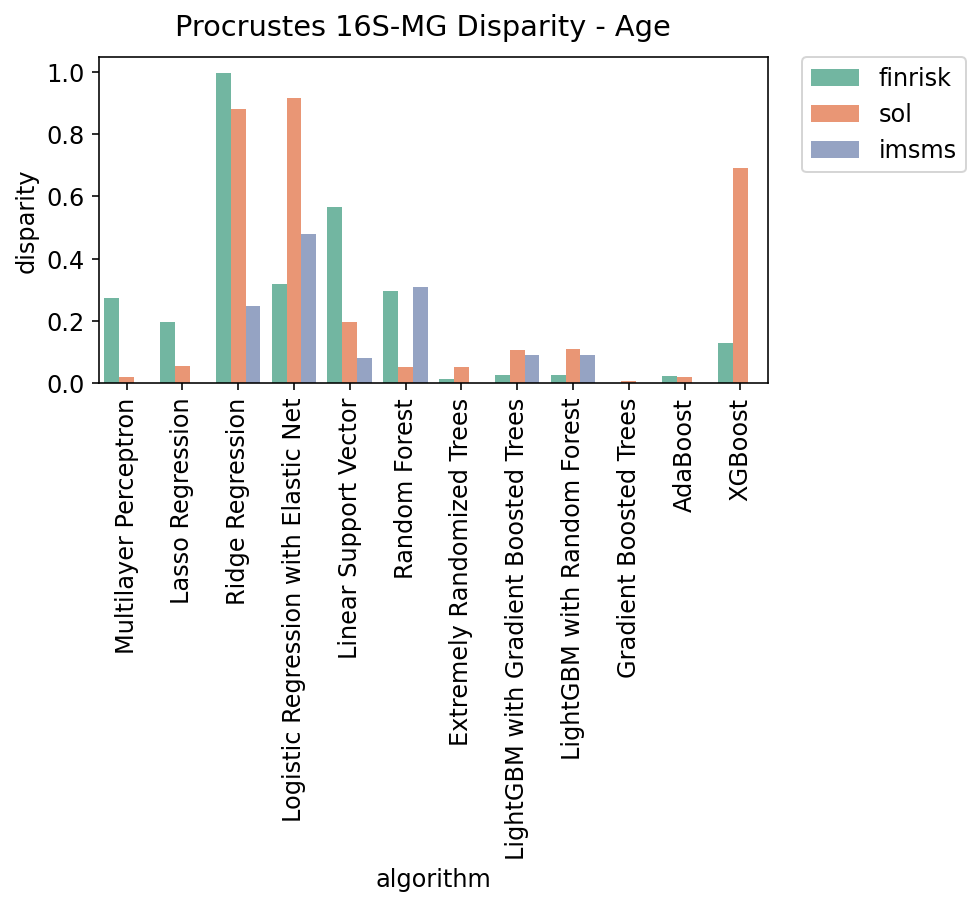

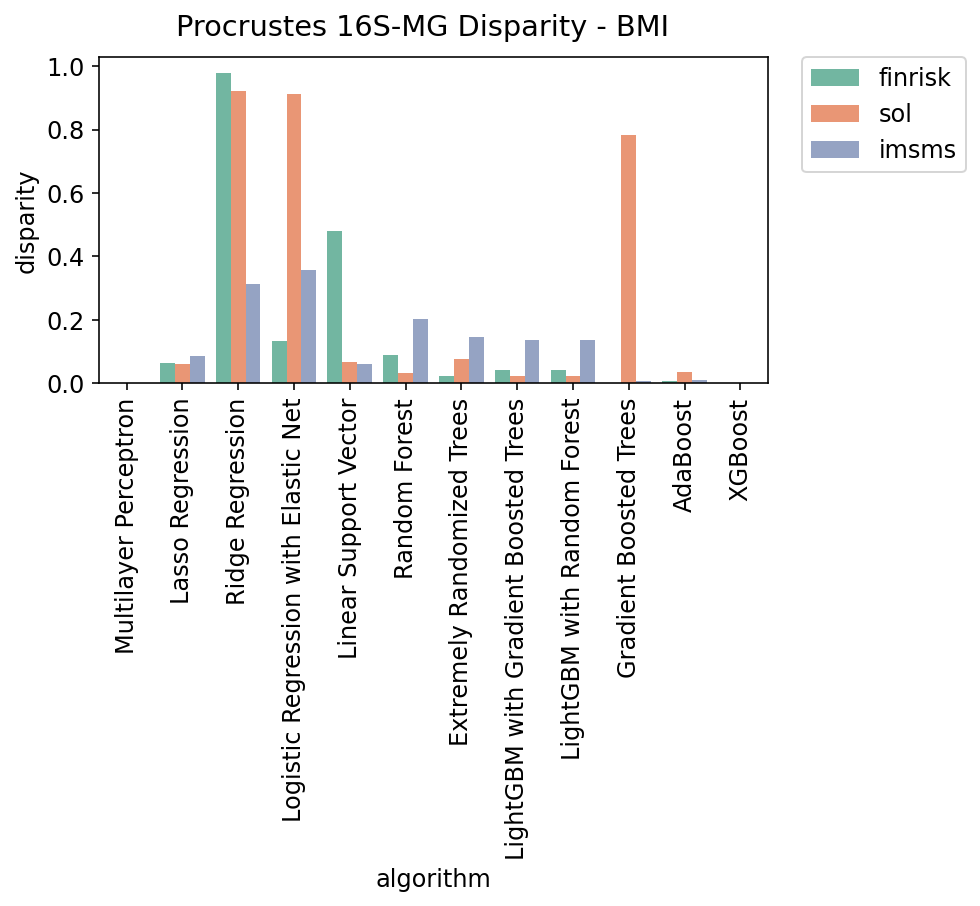

In [22]:
procrust_barplot(between_prep_results.query("target=='age'"),
                 x="algorithm", hue="dataset", palette="Set2",
                 title="Procrustes 16S-MG Disparity - Age")
procrust_barplot(between_prep_results.query("target=='bmi'"),
                 x="algorithm", hue="dataset", palette="Set2", 
                 title="Procrustes 16S-MG Disparity - BMI")

Needs interpretation - why is LGBM low disparity (more robust/transferrable hyperparameters)

Are some datasets more "difficult" than others:
Are there low-accuracy datasets? Low-accuracy predictive targets?
Does this correspond to between-dataset disparity?
(If all models are bad, disparity will be low? If the problem is extremely easy, disparity will also be low or does this break the relative performance of algorithms?)

In [23]:
prep_a = []
prep_b = []
targets = []
levels = []
algorithms = []
disparities = []
null_disparities = []
percentiles = []
for a, b in combinations(df["dataset"].unique(), 2):
    for target in df["target"].unique():
        for level in df["level"].unique():
            print(a,b,target,level)
            # Filter to intersection across parameters id
            for algorithm in df["algorithm"].unique():
                a_query = df.query(f"dataset == '{a}' & target == '{target}' & level == '{level}' & algorithm == '{algorithm}'")
                b_query = df.query(f"dataset == '{b}' & target == '{target}' & level == '{level}' & algorithm == '{algorithm}'")
                
                # ignore if either of these has no results
                if a_query.shape[0]==0 or b_query.shape[0]==0:
                    continue
                
                a_query.set_index("parameters_id", inplace=True)
                b_query.set_index("parameters_id", inplace=True)
                
                # Filter nans and inf from columns in procrustes matrix
                matrix_cols = ["standardized_MAE_mean", "standardized_MAE_var"]
                a_query = a_query.replace([np.inf, -np.inf], np.nan)
                b_query = b_query.replace([np.inf, -np.inf], np.nan)
                a_query = a_query.dropna(axis="index", how="any", subset=matrix_cols)
                b_query = b_query.dropna(axis="index", how="any", subset=matrix_cols)
                
                # Filter to the same subset of parameter ids
                shared_params = list(set(a_query.index).intersection(b_query.index))
                a_filtered = a_query.loc[shared_params]
                b_filtered = b_query.loc[shared_params]
                print(len(shared_params), a_filtered.shape, b_filtered.shape)
                
                # Get matrices of same size
                a_matrix = a_filtered[["standardized_MAE_mean", "standardized_MAE_var"]].to_numpy()
                b_matrix = b_filtered[["standardized_MAE_mean", "standardized_MAE_var"]].to_numpy()
                
                # procrustes!
                mtx1, mtx2, disparity = procrustes(a_matrix, b_matrix)
                
                # Get null dist and mean null disparity
                null_distribution, null_disparity = get_null_disparities(
                    a_matrix, b_matrix, n_repeats=500
                )
                
                prep_a.append(a)
                prep_b.append(b)
                targets.append(target)
                levels.append(level)
                algorithms.append(algorithm)
                disparities.append(disparity)
                null_disparities.append(null_disparity)
                percentiles.append(percentileofscore(null_distribution, disparity))

results = pd.DataFrame()
results["dataset_a"] = prep_a
results["dataset_b"] = prep_b
results["preparation_pair"] = list(zip(prep_a, prep_b))
results["target"] = targets
results["level"] = levels
results["algorithm"] = algorithms
results["disparity"] = disparities
results["null_disparity"] = null_disparities
results["percentiles"] = percentiles
between_dataset_results = results 
between_dataset_results

finrisk imsms age 16S
168 (168, 24) (168, 24)



80 (80, 24) (80, 24)



677 (677, 24) (677, 24)



980 (980, 24) (980, 24)



892 (892, 24) (892, 24)



896 (896, 24) (896, 24)



1000 (1000, 24) (1000, 24)



finrisk imsms age MG
168 (168, 24) (168, 24)



112 (112, 24) (112, 24)



724 (724, 24) (724, 24)



993 (993, 24) (993, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



finrisk imsms bmi 16S
56 (56, 24) (56, 24)



504 (504, 24) (504, 24)



112 (112, 24) (112, 24)



667 (667, 24) (667, 24)



457 (457, 24) (457, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



227 (227, 24) (227, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



877 (877, 24) (877, 24)



23 (23, 24) (23, 24)



finrisk imsms bmi MG
56 (56, 24) (56, 24)



504 (504, 24) (504, 24)



112 (112, 24) (112, 24)



624 (624, 24) (624, 24)



526 (526, 24) (526, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



549 (549, 24) (549, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



879 (879, 24) (879, 24)



590 (590, 24) (590, 24)



finrisk sol age 16S
56 (56, 24) (56, 24)



168 (168, 24) (168, 24)



80 (80, 24) (80, 24)



675 (675, 24) (675, 24)



807 (807, 24) (807, 24)



942 (942, 24) (942, 24)



776 (776, 24) (776, 24)



822 (822, 24) (822, 24)



477 (477, 24) (477, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



36 (36, 24) (36, 24)



finrisk sol age MG
56 (56, 24) (56, 24)



168 (168, 24) (168, 24)



79 (79, 24) (79, 24)



724 (724, 24) (724, 24)



914 (914, 24) (914, 24)



993 (993, 24) (993, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



477 (477, 24) (477, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



36 (36, 24) (36, 24)



finrisk sol bmi 16S
56 (56, 24) (56, 24)



504 (504, 24) (504, 24)



112 (112, 24) (112, 24)



667 (667, 24) (667, 24)



457 (457, 24) (457, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



172 (172, 24) (172, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



914 (914, 24) (914, 24)



23 (23, 24) (23, 24)



finrisk sol bmi MG
56 (56, 24) (56, 24)



504 (504, 24) (504, 24)



112 (112, 24) (112, 24)



624 (624, 24) (624, 24)



526 (526, 24) (526, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



431 (431, 24) (431, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



986 (986, 24) (986, 24)



590 (590, 24) (590, 24)



imsms sol age 16S
168 (168, 24) (168, 24)



85 (85, 24) (85, 24)



978 (978, 24) (978, 24)



962 (962, 24) (962, 24)



884 (884, 24) (884, 24)



926 (926, 24) (926, 24)



1000 (1000, 24) (1000, 24)



imsms sol age MG
168 (168, 24) (168, 24)



79 (79, 24) (79, 24)



980 (980, 24) (980, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



imsms sol bmi 16S
56 (56, 24) (56, 24)



600 (600, 24) (600, 24)



112 (112, 24) (112, 24)



937 (937, 24) (937, 24)



794 (794, 24) (794, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



763 (763, 24) (763, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



813 (813, 24) (813, 24)



84 (84, 24) (84, 24)



imsms sol bmi MG
56 (56, 24) (56, 24)



573 (573, 24) (573, 24)



112 (112, 24) (112, 24)



980 (980, 24) (980, 24)



931 (931, 24) (931, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



1000 (1000, 24) (1000, 24)



765 (765, 24) (765, 24)



27 (27, 24) (27, 24)



1000 (1000, 24) (1000, 24)



872 (872, 24) (872, 24)



1000 (1000, 24) (1000, 24)


,dataset_a,dataset_b,preparation_pair,target,level,algorithm,disparity,null_disparity,percentiles
0,finrisk,imsms,"(finrisk, imsms)",age,16S,RidgeRegressor,0.905438,0.993908,0.0
1,finrisk,imsms,"(finrisk, imsms)",age,16S,LinearSVR,0.574923,0.986777,0.0
2,finrisk,imsms,"(finrisk, imsms)",age,16S,RandomForestRegressor,0.308241,0.998538,0.0
3,finrisk,imsms,"(finrisk, imsms)",age,16S,XGBRegressor,0.453923,0.998939,0.0
4,finrisk,imsms,"(finrisk, imsms)",age,16S,LGBMRegressor_GBDT,0.110338,0.998785,0.0
...,...,...,...,...,...,...,...,...,...
125,imsms,sol,"(imsms, sol)",bmi,MG,GradientBoostingRegressor,0.426691,0.998635,0.0
126,imsms,sol,"(imsms, sol)",bmi,MG,AdaBoostRegressor,0.097783,0.958246,0.0
127,imsms,sol,"(imsms, sol)",bmi,MG,ElasticNet,0.393709,0.998989,0.0
128,imsms,sol,"(imsms, sol)",bmi,MG,MLPRegressor,0.000000,0.000000,50.1


In [24]:
hyperparameter_size_dict = {}
for algorithm in df.algorithm.unique():
    hyperparameter_size_dict[algorithm] = min(1000, ParameterGrids.get_size(algorithm))

def procrust_barplot_hor(results, x, hue, palette, title):
    # plot average dispersion by algorithm
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    
    #fig, ax = plt.subplots(figsize=(10,10))
    results["algorithm_family"] = [algorithm_to_family[a] for a in results["algorithm"]]
    
    algorithms = [
        'MLPRegressor',
        'Lasso', 
        'RidgeRegressor',
        'ElasticNet', 
        'LinearSVR', 
        'RandomForestRegressor',
        'ExtraTreesRegressor', 
        'LGBMRegressor_GBDT',
        'LGBMRegressor_RF', 
        'GradientBoostingRegressor',
        'AdaBoostRegressor',
        'XGBRegressor',
    ]
    algorithm_ordering, ordering_values = order_by_paramspace_cardinality(
        melted_df_withnullmodel
    )
    g = sns.FacetGrid(results, col="level", row="target")
    g.map_dataframe(
        sns.boxplot,
        orient='h',
        y=x,
        x="null_disparity",
        order=algorithm_ordering,
        #hue=hue,
        data=results,
        linewidth=3.0,
        #size=10.0,
#         ax=ax,
        palette=palette
    )
    g.map_dataframe(
        sns.barplot,
        orient='h',
        y=x,
        x="disparity",
        order=algorithm_ordering,
        hue="algorithm_family",
        data=results,
        dodge=False,
        #linewidth=1.0,
        #size=10.0,
#         ax=ax,
        palette=palette
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set_axis_labels("Disparity")
    plt.tight_layout()
    g.axes[0][0].set_yticklabels([readablename[alg] for alg in algorithm_ordering])

#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.xticks(rotation = 90)
    g.fig.suptitle(title, y=1.05, x=.7)
#     fig.set_size_inches(6, 3)

In [25]:
procrust_barplot_hor(
    between_dataset_results.query(
        "dataset_a=='finrisk' & dataset_b=='imsms'"
    ), 
    x="algorithm", hue="level", palette="Set1", 
    title="FINRISK-iMSMS Disparity"
)
procrust_barplot_hor(
    between_dataset_results.query(
        "dataset_a=='finrisk' & dataset_b=='sol'"
    ), 
    x="algorithm", hue="level", palette="Set1", 
    title="FINRISK-SOL Disparity"
)
procrust_barplot_hor(
    between_dataset_results.query(
        "dataset_a=='imsms' & dataset_b=='sol'"
    ), 
    x="algorithm", hue="level", palette="Set1", 
    title="iMSMS-SOL Disparity"
)

/Users/pmcgrath/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


NameError: name 'melted_df_withnullmodel' is not defined

In [ ]:
def procrust_barplot_hor(results, x, hue, palette, title):
    # plot average dispersion by algorithm
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    
    results["algorithm_family"] = [algorithm_to_family[a] for a in results["algorithm"]]
    
    #fig, ax = plt.subplots(figsize=(10,10))
    
    algorithms = [
        'MLPRegressor',
        'Lasso', 
        'RidgeRegressor',
        'ElasticNet', 
        'LinearSVR', 
        'RandomForestRegressor',
        'ExtraTreesRegressor', 
        'LGBMRegressor_GBDT',
        'LGBMRegressor_RF', 
        'GradientBoostingRegressor',
        'AdaBoostRegressor',
        'XGBRegressor',
    ]
    algorithm_ordering, ordering_values = order_by_paramspace_cardinality(
        melted_df_withnullmodel
    )
    g = sns.FacetGrid(results, col="dataset", row="target")
    g.map_dataframe(
        sns.boxplot,
        orient='h',
        y=x,
        x="null_disparity",
        order=algorithm_ordering,
        #hue=hue,
        data=results,
        linewidth=3.0,
        #size=10.0,
#         ax=ax,
        palette=palette
    )
    g.map_dataframe(
        sns.barplot,
        orient='h',
        y=x,
        x="disparity",
        order=algorithm_ordering,
        hue="algorithm_family",
        dodge=False,
        data=results,
        #linewidth=1.0,
        #size=10.0,
#         ax=ax,
        palette=palette
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.set_axis_labels("Disparity")
    plt.tight_layout()
    g.axes[0][0].set_yticklabels([readablename[alg] for alg in algorithm_ordering])

    g.axes[0][0].legend(bbox_to_anchor=(3.40, 1), loc=2, borderaxespad=0.)
#     plt.xticks(rotation = 90)
    g.fig.suptitle(title, y=1.05)
#     fig.set_size_inches(6, 3)

procrust_barplot_hor(
    between_prep_results, 
    x="algorithm", hue="dataset", palette="Set1", 
    title="16S-MG Disparity"
)

In [ ]:
[a for a in df["algorithm"].unique() if algorithm_to_family[a] in ["Ensemble", "Boosting"]]

In [ ]:
# Scatterplots
algs_to_scatter=[
    'RandomForestRegressor',
    'ExtraTreesRegressor',
    'XGBRegressor',
    'LGBMRegressor_GBDT',
    'LGBMRegressor_RF',
    'GradientBoostingRegressor',
    'AdaBoostRegressor'
]

for a, b in combinations(df["dataset"].unique(), 2):
    fig, axs = plt.subplots(
        5,6, 
        figsize=(20, 12), 
        #sharex=True, 
        #sharey=True
    )
    plt.subplots_adjust(hspace=.5, wspace=.4)
    axs_idx = 0
    for algorithm in algs_to_scatter:
        for target in df["target"].unique():
            for level in df["level"].unique():
                #print(a,b,target,level)
                # Filter to intersection across parameters id
            
                a_query = df.query(
                    f"dataset == '{a}' & target == '{target}' & level == '{level}' & algorithm == '{algorithm}'"
                    +f" & standardized_MAE_mean<=0.9"
                )
                b_query = df.query(
                    f"dataset == '{b}' & target == '{target}' & level == '{level}' & algorithm == '{algorithm}'"
                    +f" & standardized_MAE_mean<=0.9"
                )
                
                # ignore if either of these has no results
                if a_query.shape[0]==0 or b_query.shape[0]==0:
                    continue
                
                a_query.set_index("parameters_id", inplace=True)
                b_query.set_index("parameters_id", inplace=True)
                
                # Filter nans and inf from columns in procrustes matrix
                matrix_cols = ["standardized_MAE_mean", "standardized_MAE_var"]
                a_query = a_query.replace([np.inf, -np.inf], np.nan)
                b_query = b_query.replace([np.inf, -np.inf], np.nan)
                a_query = a_query.dropna(axis="index", how="any", subset=matrix_cols)
                b_query = b_query.dropna(axis="index", how="any", subset=matrix_cols)
                
                # Filter to the same subset of parameter ids
                shared_params = list(set(a_query.index).intersection(b_query.index))
                a_filtered = a_query.loc[shared_params]
                b_filtered = b_query.loc[shared_params]
                #print(len(shared_params), a_filtered.shape, b_filtered.shape)
                
                # Get matrices of same size
                a_matrix = a_filtered["standardized_MAE_mean"].to_numpy()
                b_matrix = b_filtered["standardized_MAE_mean"].to_numpy()
                
                plot_dict = {
                    a: a_matrix,
                    b: b_matrix
                }
                plot_df = pd.DataFrame(plot_dict)
                
                ax = axs.flat[axs_idx]
                sns.regplot(
                    data=plot_df,
                    x=a,
                    y=b,
                    ax=ax, 
                    scatter_kws={
                        "alpha": 0.05
                    },
                    line_kws={'color':'red'}
                )
                ax.set_title(f"{algorithm}\n {target}, {level}", fontsize=10)
                axs_idx += 1

In [ ]:
sns.scatterplot(data=plot_df, x='imsms', y='sol')

In [ ]:
# Scatterplots
algs_to_scatter=[
    'RandomForestRegressor',
    'ExtraTreesRegressor',
    'XGBRegressor',
    'LGBMRegressor_GBDT',
    'LGBMRegressor_RF',
    'GradientBoostingRegressor',
    'AdaBoostRegressor'
]

fig, axs = plt.subplots(
    7,6, 
    figsize=(20, 15), 
    sharex=True, 
    sharey=True
)
plt.subplots_adjust(hspace=.5, wspace=.4)
axs_idx = 0
a = '16S'
b = 'MG'
for algorithm in algs_to_scatter:
    for target in df["target"].unique():
        #print(a,b,target,level)
        # Filter to intersection across parameters id
        for dataset in df["dataset"].unique():
            a_query = df.query(
                f"dataset == '{dataset}' & target == '{target}' & level == '{a}' & algorithm == '{algorithm}'"
                +f" & standardized_MAE_mean<=0.9"
            )
            b_query = df.query(
                f"dataset == '{dataset}' & target == '{target}' & level == '{b}' & algorithm == '{algorithm}'"
                +f" & standardized_MAE_mean<=0.9"
            )

            # ignore if either of these has no results
            if a_query.shape[0]==0 or b_query.shape[0]==0:
                continue

            # Filter to the same subset of parameter ids
            a_query.set_index("parameters_id", inplace=True)
            b_query.set_index("parameters_id", inplace=True)
            
            # Filter nans and inf from columns in procrustes matrix
            matrix_cols = ["standardized_MAE_mean", "standardized_MAE_var"]
            a_query = a_query.replace([np.inf, -np.inf], np.nan)
            b_query = b_query.replace([np.inf, -np.inf], np.nan)
            a_query = a_query.dropna(axis="index", how="any", subset=matrix_cols)
            b_query = b_query.dropna(axis="index", how="any", subset=matrix_cols)

                
            shared_params = list(set(a_query.index).intersection(b_query.index))

            a_filtered = a_query.loc[shared_params]
            b_filtered = b_query.loc[shared_params]
            #print(len(shared_params), a_filtered.shape, b_filtered.shape)

            # Get matrices of same size
            a_matrix = a_filtered["standardized_MAE_mean"].to_numpy()
            b_matrix = b_filtered["standardized_MAE_mean"].to_numpy()

            plot_dict = {
                a: a_matrix,
                b: b_matrix
            }
            plot_df = pd.DataFrame(plot_dict)

            ax = axs.flat[axs_idx]
            sns.regplot(
                data=plot_df,
                x=a,
                y=b,
                ax=ax, 
                scatter_kws={
                    "alpha": 0.05
                },
                line_kws={'color':'red'}
            )
            ax.set_title(f"{algorithm}\n {dataset}, {target}", fontsize=10)
            axs_idx += 1

In [ ]:
# Scatterplots
algs_to_scatter=[
    'RandomForestRegressor',
    'ExtraTreesRegressor',
    'XGBRegressor',
    'LGBMRegressor_GBDT',
    'LGBMRegressor_RF',
    'GradientBoostingRegressor',
    'AdaBoostRegressor'
]

fig, axs = plt.subplots(
    7,6, 
    figsize=(20, 15), 
    sharex=True, 
    sharey=True
)
plt.subplots_adjust(hspace=.3, wspace=.1)
plt.xlabel("standardized MAE")
plt.ylabel("standardized MAE")
axs_idx = 0
a = '16S'
b = 'MG'
for algorithm in algs_to_scatter:
    for target in df["target"].unique():
        #print(a,b,target,level)
        # Filter to intersection across parameters id
        for dataset in df["dataset"].unique():
            a_query = df.query(
                f"dataset == '{dataset}' & target == '{target}' & level == '{a}' & algorithm == '{algorithm}'"
                +f" & standardized_MAE_mean<=0.85"
            )
            b_query = df.query(
                f"dataset == '{dataset}' & target == '{target}' & level == '{b}' & algorithm == '{algorithm}'"
                +f" & standardized_MAE_mean<=0.85"
            )

            # ignore if either of these has no results
            if a_query.shape[0]==0 or b_query.shape[0]==0:
                continue

            # Filter to the same subset of parameter ids
            a_query.set_index("parameters_id", inplace=True)
            b_query.set_index("parameters_id", inplace=True)
            
            # Filter nans and inf from columns in procrustes matrix
            matrix_cols = ["standardized_MAE_mean", "standardized_MAE_var"]
            a_query = a_query.replace([np.inf, -np.inf], np.nan)
            b_query = b_query.replace([np.inf, -np.inf], np.nan)
            a_query = a_query.dropna(axis="index", how="any", subset=matrix_cols)
            b_query = b_query.dropna(axis="index", how="any", subset=matrix_cols)
            
            shared_params = list(set(a_query.index).intersection(b_query.index))
            a_filtered = a_query.loc[shared_params]
            b_filtered = b_query.loc[shared_params]
            #print(len(shared_params), a_filtered.shape, b_filtered.shape)

            # Get matrices of same size
            a_matrix = a_filtered["standardized_MAE_mean"].to_numpy()
            b_matrix = b_filtered["standardized_MAE_mean"].to_numpy()

            plot_dict = {
                a: a_matrix,
                b: b_matrix
            }
            plot_df = pd.DataFrame(plot_dict)

            ax = axs.flat[axs_idx]
            sns.histplot(
                data=plot_df,
                x=a,
                y=b,
                ax=ax, 
                bins=20,
                cbar=False,
            )
            ax.plot(
                [0,1],
                [0,1],
                'grey',
                transform=ax.transAxes,
            )
            ax.set_title(f"{algorithm}\n {dataset}, {target}", fontsize=10)
            axs_idx += 1

In [ ]:
# Scatterplots
algs_to_scatter=[
    'RandomForestRegressor',
    #'ExtraTreesRegressor',
    'XGBRegressor',
    'LGBMRegressor_GBDT',
    #'LGBMRegressor_RF',
    #'GradientBoostingRegressor',
    #'AdaBoostRegressor'
]

a = '16S'
b = 'MG'
all_alg_dfs = []
for dataset in df["dataset"].unique():
    for target in df["target"].unique():
        #print(a,b,target,level)
        # Filter to intersection across parameters id
        for algorithm in algs_to_scatter:
            a_query = df.query(
                f"dataset == '{dataset}' & target == '{target}' & level == '{a}' & algorithm == '{algorithm}'"
                +f" & standardized_MAE_mean<=0.85"
            )
            b_query = df.query(
                f"dataset == '{dataset}' & target == '{target}' & level == '{b}' & algorithm == '{algorithm}'"
                +f" & standardized_MAE_mean<=0.85"
            )

            # ignore if either of these has no results
            if a_query.shape[0]==0 or b_query.shape[0]==0:
                continue

            a_query.set_index("parameters_id", inplace=True)
            b_query.set_index("parameters_id", inplace=True)
            
            # Filter nans and inf from columns in procrustes matrix
            matrix_cols = ["standardized_MAE_mean", "standardized_MAE_var"]
            a_query = a_query.replace([np.inf, -np.inf], np.nan)
            b_query = b_query.replace([np.inf, -np.inf], np.nan)
            a_query = a_query.dropna(axis="index", how="any", subset=matrix_cols)
            b_query = b_query.dropna(axis="index", how="any", subset=matrix_cols)
            
            # Filter to the same subset of parameter ids
            shared_params = list(set(a_query.index).intersection(b_query.index))
            a_filtered = a_query.loc[shared_params]
            b_filtered = b_query.loc[shared_params]
            #print(len(shared_params), a_filtered.shape, b_filtered.shape)

            # Get matrices of same size
            a_matrix = a_filtered["standardized_MAE_mean"].to_numpy()
            b_matrix = b_filtered["standardized_MAE_mean"].to_numpy()
            g_minus_16S_matrix = b_matrix - a_matrix

            plot_dict = {
                a: a_matrix,
                b: b_matrix,
                "MG-16S difference": g_minus_16S_matrix,
                "algorithm": algorithm,
                "target": target,
                "dataset": dataset,
            }
            plot_df = pd.DataFrame(plot_dict)
            all_alg_dfs.append(plot_df)
        
all_algs_table = pd.concat(all_alg_dfs)

In [ ]:
all_algs_table["target"].unique()

In [ ]:
g = sns.FacetGrid(
    all_algs_table.query("dataset=='sol'"),
    row="algorithm",
    col="target",
    sharex=True,
    legend_out=True,
    height=2, aspect=2
)
g.map_dataframe(
    sns.residplot,
    x="16S",
    y="MG",
    scatter_kws={
        "alpha": 0.05
    },
    line_kws={'color':'red'}
)

# Plot relplot with best fit line and plot y=x
# color dataset by our color key

g.set_axis_labels("16S performance (standardized MAE)", "Residuals")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.suptitle("Regression residuals from 16S vs MG performance in SOL", y=1.02)
plt.tight_layout()
# for ax in g.axes.flatten():
#     ax.plot(
#         [0,1],
#         [0,1],
#         'grey',
#         transform=ax.transAxes,
#     )

In [ ]:
dataset = "finrisk"
name = "FINRISK"
color = "blue"
g = sns.FacetGrid(
    all_algs_table.query(f"dataset=='{dataset}'"),
    row="algorithm",
    col="target",
    sharex=True,
    legend_out=True,
    height=2, aspect=2
)
g.map_dataframe(
    sns.scatterplot,
    x="16S",
    y="MG-16S difference",
    alpha=0.05,
    color=color
)

# Plot relplot with best fit line and plot y=x
# color dataset by our color key

g.set_axis_labels("16S performance (standardized MAE)", "MG minus 16S")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.suptitle(f"Difference in MG vs 16S performance in {name}", y=1.02)
plt.tight_layout()
for ax in g.axes.flatten():
    ax.axhline(
        0,
        color='grey',
        linestyle='--'
    )

In [ ]:
dataset = "imsms"
name = "iMSMS"
color = "orange"
g = sns.FacetGrid(
    all_algs_table.query(f"dataset=='{dataset}'"),
    row="algorithm",
    col="target",
    sharex=True,
    legend_out=True,
    height=2, aspect=2
)
g.map_dataframe(
    sns.scatterplot,
    x="16S",
    y="MG-16S difference",
    alpha=0.05,
    color=color
)

# Plot relplot with best fit line and plot y=x
# color dataset by our color key

g.set_axis_labels("16S performance (standardized MAE)", "MG minus 16S")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.suptitle(f"Difference in MG vs 16S performance in {name}", y=1.02)
plt.tight_layout()
for ax in g.axes.flatten():
    ax.axhline(
        0,
        color='grey',
        linestyle='--'
    )

In [ ]:
dataset = "sol"
name = "SOL"
color = "green"
g = sns.FacetGrid(
    all_algs_table.query(f"dataset=='{dataset}'"),
    row="algorithm",
    col="target",
    sharex=True,
    legend_out=True,
    height=2, aspect=2
)
g.map_dataframe(
    sns.scatterplot,
    x="16S",
    y="MG-16S difference",
    alpha=0.05,
    color=color
)

# Plot relplot with best fit line and plot y=x
# color dataset by our color key

g.set_axis_labels("16S performance (standardized MAE)", "MG minus 16S")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.suptitle(f"Difference in MG vs 16S performance in {name}", y=1.02)
plt.tight_layout()
for ax in g.axes.flatten():
    ax.axhline(
        0,
        color='grey',
        linestyle='--'
    )

## 3D: Runtime total improvement from transferring hyperparameters vs full grid search

Runtime of total hyperparameter space time vs runtime of best parameter set for each algorithm
Averaged from 6 values (each dataset and each target)

In [ ]:
# Scatterplots
algs_to_scatter=[
    'RandomForestRegressor',
    'ExtraTreesRegressor',
    'XGBRegressor',
    'LGBMRegressor_GBDT',
    'LGBMRegressor_RF',
    'GradientBoostingRegressor',
    'AdaBoostRegressor'
]

a = "16S"
b = "MG"
runtime_dfs = []
for dataset in df["dataset"].unique():
    for target in df["target"].unique():
        #print(a,b,target,level)
        # Filter to intersection across parameters id
        for algorithm in algs_to_scatter:
            a_query = df.query(
                f"dataset == '{dataset}' & target == '{target}' & level == '{a}' & algorithm == '{algorithm}'"
                +f" & standardized_MAE_mean<=0.85"
            )
            b_query = df.query(
                f"dataset == '{dataset}' & target == '{target}' & level == '{b}' & algorithm == '{algorithm}'"
                +f" & standardized_MAE_mean<=0.85"
            )

            # ignore if either of these has no results
            if a_query.shape[0]==0 or b_query.shape[0]==0:
                continue

            a_query.set_index("parameters_id", inplace=True)
            b_query.set_index("parameters_id", inplace=True)
            
            # Filter nans and inf from columns in procrustes matrix
            matrix_cols = ["standardized_MAE_mean", "standardized_MAE_var", "RUNTIME_mean"]
            a_query = a_query.replace([np.inf, -np.inf], np.nan)
            b_query = b_query.replace([np.inf, -np.inf], np.nan)
            a_query = a_query.dropna(axis="index", how="any", subset=matrix_cols)
            b_query = b_query.dropna(axis="index", how="any", subset=matrix_cols)
            
            # Filter to the same subset of parameter ids
            shared_params = list(set(a_query.index).intersection(b_query.index))
            a_filtered = a_query.loc[shared_params]
            b_filtered = b_query.loc[shared_params]
            
            #print(len(shared_params), a_filtered.shape, b_filtered.shape)

            # Get matrices of same size
            a_matrix = a_filtered["standardized_MAE_mean"].to_numpy()
            b_matrix = b_filtered["standardized_MAE_mean"].to_numpy()
            g_minus_16S_matrix = b_matrix - a_matrix
            
            # Get total runtime
            tot_16S_runtime = a_filtered["RUNTIME_mean"].to_numpy().sum()
            tot_MG_runtime = b_filtered["RUNTIME_mean"].to_numpy().sum()
            
            # Get runtime of model with the best MAE
            loc_min = a_filtered["standardized_MAE_mean"].idxmin(axis=0)
            min_MAE_16S_runtime = a_filtered["RUNTIME_mean"][loc_min]
            loc_min = b_filtered["standardized_MAE_mean"].idxmin(axis=0)
            min_MAE_MG_runtime = b_filtered["RUNTIME_mean"][loc_min]
            
        
            plot_dict = {
                a: a_matrix,
                b: b_matrix,
                "MG-16S difference": g_minus_16S_matrix,
                "algorithm": algorithm,
                "target": target,
                "dataset": dataset,
                "best_16S_model_runtime": min_MAE_16S_runtime,
                "best_MG_model_runtime": min_MAE_MG_runtime,
                "total_16S_runtime": tot_16S_runtime,
                "total_MG_runtime": tot_MG_runtime,
            }
            plot_df = pd.DataFrame(plot_dict)
            runtime_dfs.append(plot_df)
        
runtime_table = pd.concat(runtime_dfs)

In [ ]:
keepcols = set(runtime_table.columns) - {"16S", "MG", "MG-16S difference"}
runtime_summary_table = runtime_table[keepcols].drop_duplicates()
runtime_summary_table = runtime_summary_table.melt(
    id_vars=["dataset","algorithm","target"],
    value_vars=["best_MG_model_runtime", "total_MG_runtime"],
    var_name="runtime_type",
    value_name="runtime"
)
runtime_summary_table

In [ ]:
g = sns.FacetGrid(
    runtime_summary_table.query(
        "algorithm in ['RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor_GBDT']"
    ),
    row="algorithm",
    col="dataset",
    sharex=True,
    legend_out=True,
    margin_titles=True,
    height=2.5, aspect=.5
)
g.map_dataframe(
    sns.barplot,
    x="target",
    y="runtime",
    hue="runtime_type",
    dodge=True,
    log=True,
    palette="Set2",
)
g.add_legend(bbox_to_anchor=(1.05, 1), loc=2)


#g.set_axis_labels("16S performance (standardized MAE)", "MG minus 16S")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.suptitle(f"Runtime difference between best model and full grid search", y=1.02)
plt.tight_layout()
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.set_yticks(
        ticks=[60, 3600, 86400, 604800]
    )
    ax.set_yticklabels(
        labels=["1 minute", "1 hour", "1 day", "1 week"]
    )

# FIG1
<a id=’FIG1’></a>
Normalizing MAE accounts for population-specific biases
* A) Histplots of target variable density by dataset
* B) rel plot showing dataset size, relation of MAE to SD in target variable
* c) Box/letter-value plots comparing raw MAE to standardized

In [6]:
size_df = pd.read_csv(dataset_size_csv)
size_df["dataset"] = ["finrisk","finrisk", "sol","sol"]
size_df["level"] = ["16S","MG","16S", "MG"]
size_df.merge(df)

,dataset,samples,features,level,parameters_id,target,algorithm,RUNTIME_var,RUNTIME_mean,R2_var,...,relative_RUNTIME_var,relative_RUNTIME_mean,relative_R2_var,relative_R2_mean,relative_RMSE_var,relative_RMSE_mean,relative_MAE_var,relative_MAE_mean,relative_standardized_MAE_var,relative_standardized_MAE_mean
0,finrisk,6430,5683,16S,1,age,Lasso,0.015074,1.042999,0.000249,...,1.996816e+05,52.553598,inf,-0.000258,inf,1.066213,inf,inf,inf,inf
1,finrisk,6430,5683,16S,1,age,RidgeRegressor,0.043548,10.570746,29.295612,...,5.768622e+05,532.628442,inf,0.021128,inf,3.569975,inf,inf,inf,inf
2,finrisk,6430,5683,16S,1,bmi,RidgeRegressor,0.205455,12.491709,129.261807,...,3.046616e+06,1123.345052,8.963984e+12,0.018674,1.018243e+05,3.972497,3.041434e+03,2.661768,982.543181,2.661626
3,finrisk,6430,5683,16S,2,age,Lasso,10.216231,60.506606,2765.251055,...,1.353313e+08,3048.747717,inf,0.274482,inf,12.311521,inf,inf,inf,inf
4,finrisk,6430,5683,16S,2,age,RidgeRegressor,0.006439,1.176173,7142.342800,...,8.529413e+04,59.263843,inf,0.626060,inf,18.715498,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44516,sol,1364,1278,MG,6052,bmi,RidgeRegressor,0.000007,0.245823,3238.554091,...,6.234245e+02,74.946297,3.576060e+12,0.254528,7.567890e+04,9.697218,1.472992e+04,6.851735,3673.457924,6.855247
44517,sol,1364,1278,MG,6053,bmi,RidgeRegressor,0.000015,0.221838,16.093500,...,1.432094e+03,67.633698,1.777068e+10,0.015589,4.629306e+03,2.580274,9.583737e+02,2.192040,226.016623,2.192365
44518,sol,1364,1278,MG,6054,bmi,RidgeRegressor,0.000007,0.039780,0.141005,...,6.413625e+02,12.127993,1.557003e+08,0.002709,1.604057e+02,1.443031,1.230326e+02,1.392663,31.014655,1.392993
44519,sol,1364,1278,MG,6055,bmi,RidgeRegressor,0.000054,0.222603,20.225916,...,5.123686e+03,67.867063,2.233376e+10,0.017484,5.334491e+03,2.707020,1.130183e+03,2.275620,266.566052,2.275956


In [7]:
melted_df = df.melt(
    id_vars=["dataset", "level", "target", "parameters_id", "algorithm"],
    value_vars=["MAE_mean", "standardized_MAE_mean"],
    var_name=["metric"],
    value_name="value",
)

In [8]:
melted_df.query("value>1")["value"].describe()

count    78170.000000
mean         8.381327
std          7.857115
min          1.000032
25%          3.888883
50%          8.225749
75%         10.362440
max        167.142486
Name: value, dtype: float64

Text(0.5, 1.05, 'MAE vs Normalized MAE, 16S data')

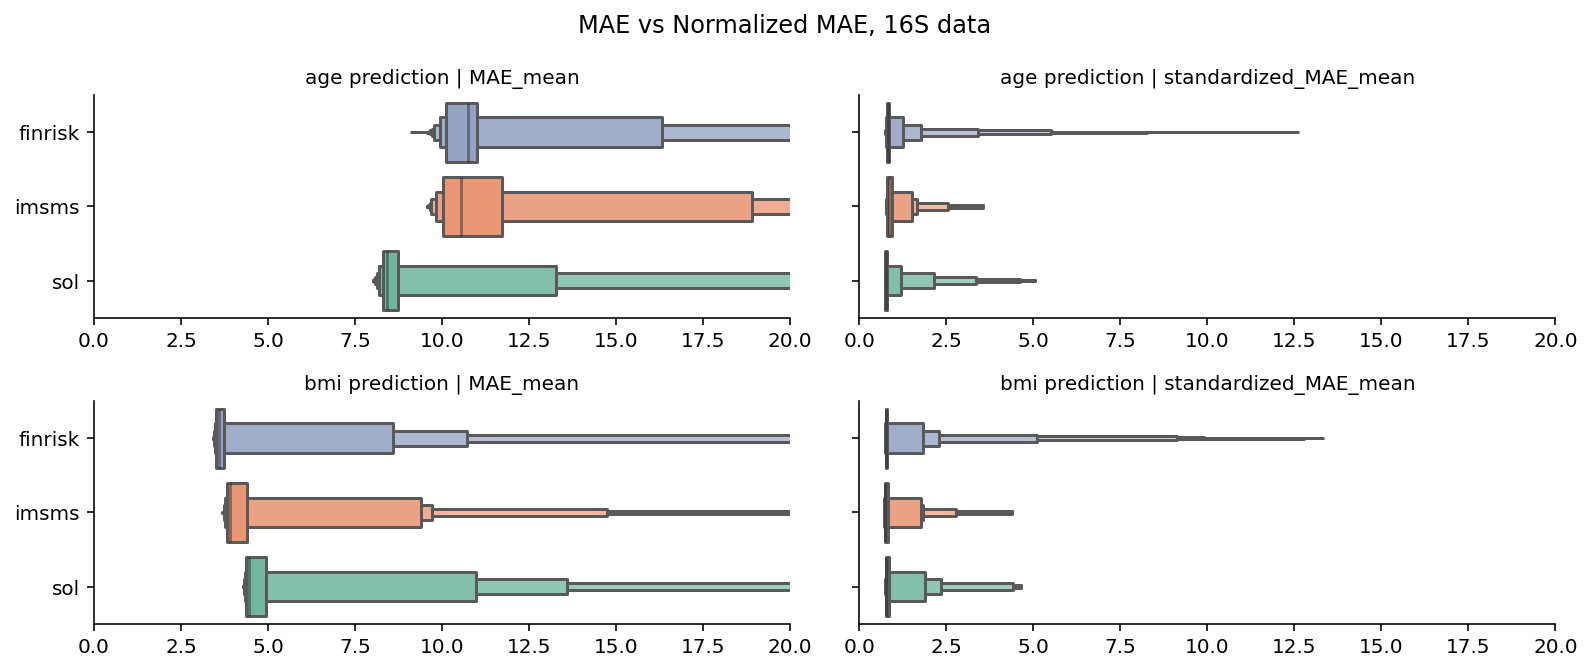

In [9]:
g = sns.FacetGrid(
    melted_df.query("level=='16S'"),
    row="target",
    col="metric",
    sharex=False,
    legend_out=True,
    height=2.2, aspect=2.5
)

g.map_dataframe(
    sns.boxenplot,
    y = "dataset",
    x = "value",
    hue = "dataset",
    hue_order=["sol", "imsms", "finrisk"],
    dodge=False,
    orient='h',
    palette=sns.color_palette("Set2"),
    showfliers=False
)

g.set(xlim=(0, 20))
g.set_titles(col_template="{col_name}", row_template="{row_name} prediction")
g.fig.subplots_adjust(wspace=0.1)
plt.suptitle("MAE vs Normalized MAE, 16S data", y=1.05)

Text(0.5, 1.05, 'MAE vs Normalized MAE')

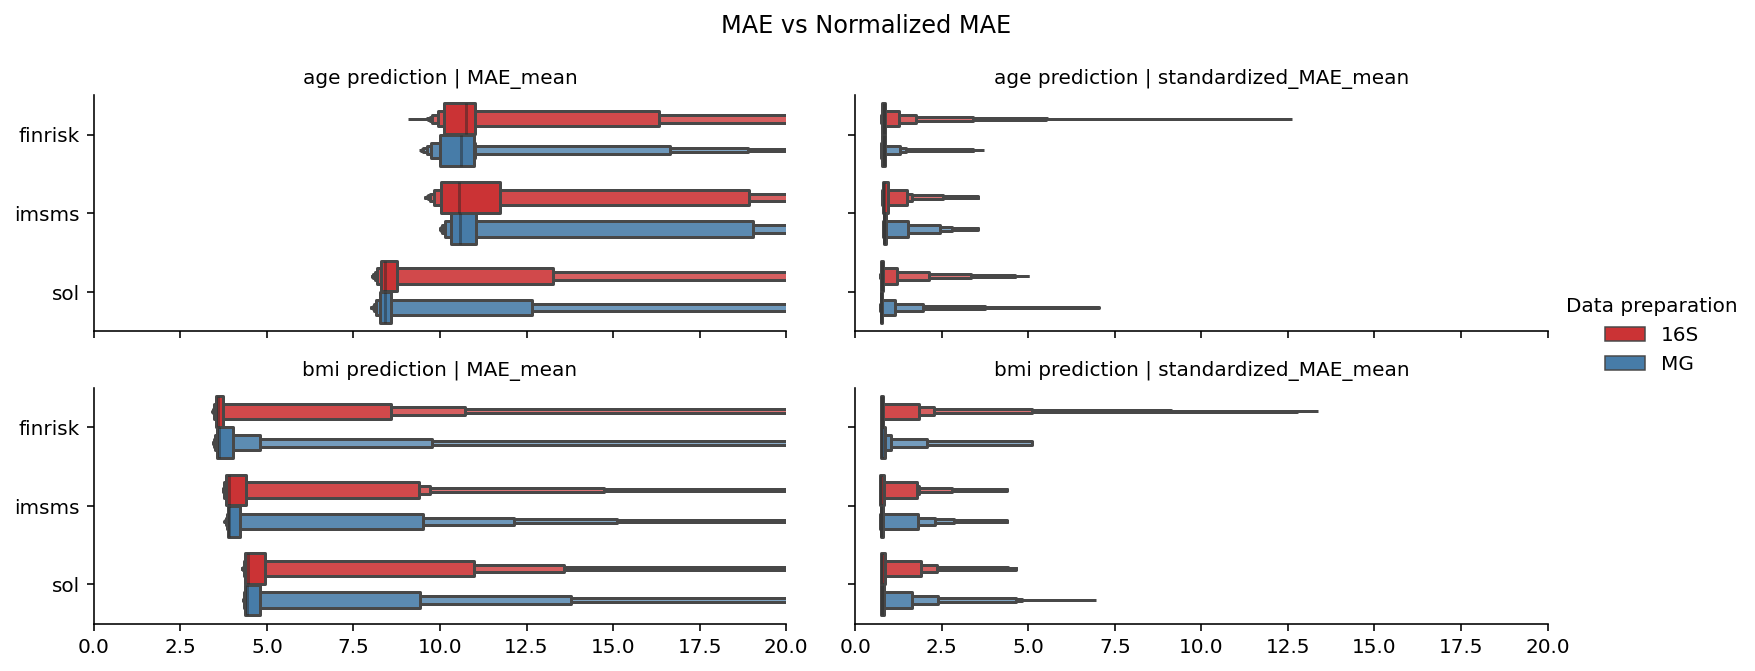

In [10]:
g = sns.FacetGrid(
    melted_df,
    row="target",
    col="metric",
    sharex=True,
    legend_out=True,
    height=2.2, aspect=2.5
)

g.map_dataframe(
    sns.boxenplot,
    y = "dataset",
    x = "value",
    hue = "level",
    #hue_order=["sol", "imsms", "finrisk"],
    dodge=True,
    orient='h',
    palette=sns.color_palette("Set1"),
    showfliers=False
)

g.set(xlim=(0, 20))
g.set_titles(col_template="{col_name}", row_template="{row_name} prediction")
g.add_legend(title="Data preparation")
g.fig.subplots_adjust(wspace=0.1)
plt.suptitle("MAE vs Normalized MAE", y=1.05)

In [11]:
normal_null_model_scores = { # normal dist
    'finrisk-16S-age': 14.696645297859746,
    'finrisk-16S-bmi': 5.249813769410967,
    'finrisk-MG-age': 14.876553422913668,
    'finrisk-MG-bmi': 5.2846796887649985,
    'sol-16S-age': 12.533141587656267,
    'sol-16S-bmi': 6.456814907620883,
    'sol-MG-age': 12.435398422101368,
    'sol-MG-bmi': 6.546434555261108,
    'imsms-16S-age': 14.235599617240027,
    'imsms-16S-bmi': 5.75570744282394,
    'imsms-MG-age': 14.509594791699218,
    'imsms-MG-bmi': 6.010216846025244
} 

mean_null_model_scores = { # mean
    'finrisk-16S-age': 11.008842899124199,
    'finrisk-16S-bmi': 3.6099480422729187,
    'finrisk-MG-age': 11.005676285051075,
    'finrisk-MG-bmi': 3.6101707963461864,
    'sol-16S-age': 8.431108447160375,
    'sol-16S-bmi': 4.377404699308495,
    'sol-MG-age': 8.437699409189808,
    'sol-MG-bmi': 4.377604496353603,
    'imsms-16S-age': 10.656447239656677,
    'imsms-16S-bmi': 3.9038037621349866,
    'imsms-MG-age': 10.617623615110315,
    'imsms-MG-bmi': 3.8993660237105168
}

median_null_model_scores = { # median
    'finrisk-16S-age': 10.979746500777605,
    'finrisk-16S-bmi': 3.573352970049782,
    'finrisk-MG-age': 10.976349626400996,
    'finrisk-MG-bmi': 3.5734209440781686,
    'sol-16S-age': 8.405445180279617,
    'sol-16S-bmi': 4.330821549940959,
    'sol-MG-age': 8.411290322580646,
    'sol-MG-bmi': 4.329213378962472,
    'imsms-16S-age': 10.649955237242613,
    'imsms-16S-bmi': 3.838911254592659,
    'imsms-MG-age': 10.608733624454148,
    'imsms-MG-bmi': 3.836397494803494
}

null_model_scores = median_null_model_scores

frames = []
for dataset, level, target, metric in product(
    melted_df.dataset.unique(),
    melted_df.level.unique(),
    melted_df.target.unique(),
    melted_df.metric.unique(),
):
    frame = melted_df.query(
        f"dataset=='{dataset}' and level=='{level}' "+
        f"and target=='{target}' and metric=='{metric}'"
    )
    raw_null_score = null_model_scores[f"{dataset}-{level}-{target}"]
    all_cv_sds = []
    for cv_fold in range(1,15):
        key = f"({dataset}, {target}, {level}, {cv_fold})"
        all_cv_sds.append(TARGET_SD.get(key, 1))
    mean_sd = np.mean(all_cv_sds)
    
    frame["target_SD_mean"] = mean_sd
    
    if metric=="MAE_mean":
        frame["null_model"] = null_model_scores[f"{dataset}-{level}-{target}"]
    if metric=="standardized_MAE_mean":
        standardized_mae = raw_null_score / mean_sd
        frame["null_model"] = standardized_mae
    
    frames.append(frame)

melted_df_withnullmodel = pd.concat(frames)
melted_df_withnullmodel

/Users/pmcgrath/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/pmcgrath/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/pmcgrath/opt/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,dataset,level,target,parameters_id,algorithm,metric,value,target_SD_mean,null_model
0,finrisk,16S,age,1,Lasso,MAE_mean,10.110120,12.985684,10.979747
1,finrisk,16S,age,1,RidgeRegressor,MAE_mean,22.886260,12.985684,10.979747
16,finrisk,16S,age,2,Lasso,MAE_mean,71.736632,12.985684,10.979747
17,finrisk,16S,age,2,RidgeRegressor,MAE_mean,106.576807,12.985684,10.979747
32,finrisk,16S,age,3,Lasso,MAE_mean,10.153145,12.985684,10.979747
...,...,...,...,...,...,...,...,...,...
133687,sol,MG,bmi,6052,RidgeRegressor,standardized_MAE_mean,5.052347,5.791598,0.747499
133695,sol,MG,bmi,6053,RidgeRegressor,standardized_MAE_mean,1.615783,5.791598,0.747499
133703,sol,MG,bmi,6054,RidgeRegressor,standardized_MAE_mean,1.026642,5.791598,0.747499
133711,sol,MG,bmi,6055,RidgeRegressor,standardized_MAE_mean,1.677390,5.791598,0.747499


In [12]:
melted_df_withnullmodel.query("metric=='MAE_mean'").value.value_counts()

3.610169     327
11.008843    317
11.005675    313
4.377583     299
3.895141     299
            ... 
10.219409      1
9.758839       1
11.816420      1
10.885909      1
10.267052      1
Name: value, Length: 40873, dtype: int64

In [13]:
dataset_sizes = {
    'finrisk-16S-age': 6430,
    'finrisk-16S-bmi': 6428,
    'finrisk-MG-age': 6424,
    'finrisk-MG-bmi': 6422,
    'sol-16S-age': 1359,
    'sol-16S-bmi': 1355,
    'sol-MG-age': 1364,
    'sol-MG-bmi': 1359,
    'imsms-16S-age': 1117,
    'imsms-16S-bmi': 1117,
    'imsms-MG-age': 1145,
    'imsms-MG-bmi': 1145
}

frames = []
for dataset, level, target in product(
    melted_df_withnullmodel.dataset.unique(),
    melted_df_withnullmodel.level.unique(),
    melted_df_withnullmodel.target.unique(),
):
    metric = "MAE_mean"
    frame = melted_df_withnullmodel.query(
        f"dataset=='{dataset}' and level=='{level}' "+
        f"and target=='{target}' and metric=='{metric}' "+
        f"and value>1"
    )
    new_frame = pd.DataFrame()
    new_frame["dataset"] = [dataset]
    new_frame["level"] = [level]
    new_frame["target"] = [target]
    new_frame["min_MAE"] = [frame.value.min()]
    new_frame["min_null"] = [frame.null_model.min()]
    new_frame["target_SD"] = [frame.target_SD_mean.unique()[0]]
    new_frame["n_samples"] = dataset_sizes[f"{dataset}-{level}-{target}"]
    
    frames.append(new_frame)

summary_df = pd.concat(frames)
summary_df

,dataset,level,target,min_MAE,min_null,target_SD,n_samples
0,finrisk,16S,age,9.543079,10.979747,12.985684,6430
0,finrisk,16S,bmi,3.416196,3.573353,4.688410,6428
0,finrisk,MG,age,9.398589,10.976350,12.983252,6424
0,finrisk,MG,bmi,3.439591,3.573421,4.689439,6422
0,imsms,16S,age,9.556747,10.649955,12.592138,1117
0,imsms,16S,bmi,3.681543,3.838911,5.300334,1117
0,imsms,MG,age,9.964458,10.608734,12.551958,1145
0,imsms,MG,bmi,3.740541,3.836397,5.285944,1145
0,sol,16S,age,8.013572,8.405445,11.130705,1359
0,sol,16S,bmi,4.265232,4.330822,5.785160,1355


In [14]:
summary_df

,dataset,level,target,min_MAE,min_null,target_SD,n_samples
0,finrisk,16S,age,9.543079,10.979747,12.985684,6430
0,finrisk,16S,bmi,3.416196,3.573353,4.688410,6428
0,finrisk,MG,age,9.398589,10.976350,12.983252,6424
0,finrisk,MG,bmi,3.439591,3.573421,4.689439,6422
0,imsms,16S,age,9.556747,10.649955,12.592138,1117
0,imsms,16S,bmi,3.681543,3.838911,5.300334,1117
0,imsms,MG,age,9.964458,10.608734,12.551958,1145
0,imsms,MG,bmi,3.740541,3.836397,5.285944,1145
0,sol,16S,age,8.013572,8.405445,11.130705,1359
0,sol,16S,bmi,4.265232,4.330822,5.785160,1355


In [15]:
frames = []
for dataset, level, target in product(
    melted_df_withnullmodel.dataset.unique(),
    melted_df_withnullmodel.level.unique(),
    melted_df_withnullmodel.target.unique(),
):
    metric = "standardized_MAE_mean"
    frame = melted_df_withnullmodel.query(
        f"dataset=='{dataset}' and level=='{level}' "+
        f"and target=='{target}' and metric=='{metric}' "
        + f"and value>0.06"
    )
    new_frame = pd.DataFrame()
    new_frame["dataset"] = [dataset]
    new_frame["level"] = [level]
    new_frame["target"] = [target]
    new_frame["min_standardized_MAE"] = [frame.value.min()]
    new_frame["min_standardized_null"] = [frame.null_model.min()]
    new_frame["target_SD"] = [frame.target_SD_mean.unique()[0]]
    new_frame["n_samples"] = dataset_sizes[f"{dataset}-{level}-{target}"]
    
    frames.append(new_frame)

summary_df_standardized = pd.concat(frames)
summary_df["min_standardized_MAE"] = summary_df_standardized["min_standardized_MAE"]
summary_df["min_standardized_null"] = summary_df_standardized["min_standardized_null"]

summary_df = summary_df.melt(
    id_vars=["dataset","level","target","target_SD","n_samples", "min_standardized_null", "min_null"],
    value_vars=["min_standardized_MAE", "min_MAE"],
    var_name=["metric"],
    value_name="value"
)
summary_df

,dataset,level,target,target_SD,n_samples,min_standardized_null,min_null,metric,value
0,finrisk,16S,age,12.985684,6430,0.845527,10.979747,min_standardized_MAE,0.734892
1,finrisk,16S,bmi,4.688410,6428,0.762167,3.573353,min_standardized_MAE,0.728723
2,finrisk,MG,age,12.983252,6424,0.845424,10.976350,min_standardized_MAE,0.723904
3,finrisk,MG,bmi,4.689439,6422,0.762015,3.573421,min_standardized_MAE,0.733560
4,imsms,16S,age,12.592138,1117,0.845762,10.649955,min_standardized_MAE,0.759028
5,imsms,16S,bmi,5.300334,1117,0.724277,3.838911,min_standardized_MAE,0.694847
6,imsms,MG,age,12.551958,1145,0.845186,10.608734,min_standardized_MAE,0.793930
7,imsms,MG,bmi,5.285944,1145,0.725773,3.836397,min_standardized_MAE,0.708125
8,sol,16S,age,11.130705,1359,0.755158,8.405445,min_standardized_MAE,0.719941
9,sol,16S,bmi,5.785160,1355,0.748609,4.330822,min_standardized_MAE,0.737004


Text(0.5, 1.05, 'SD of target related to minimum MAE for each dataset')

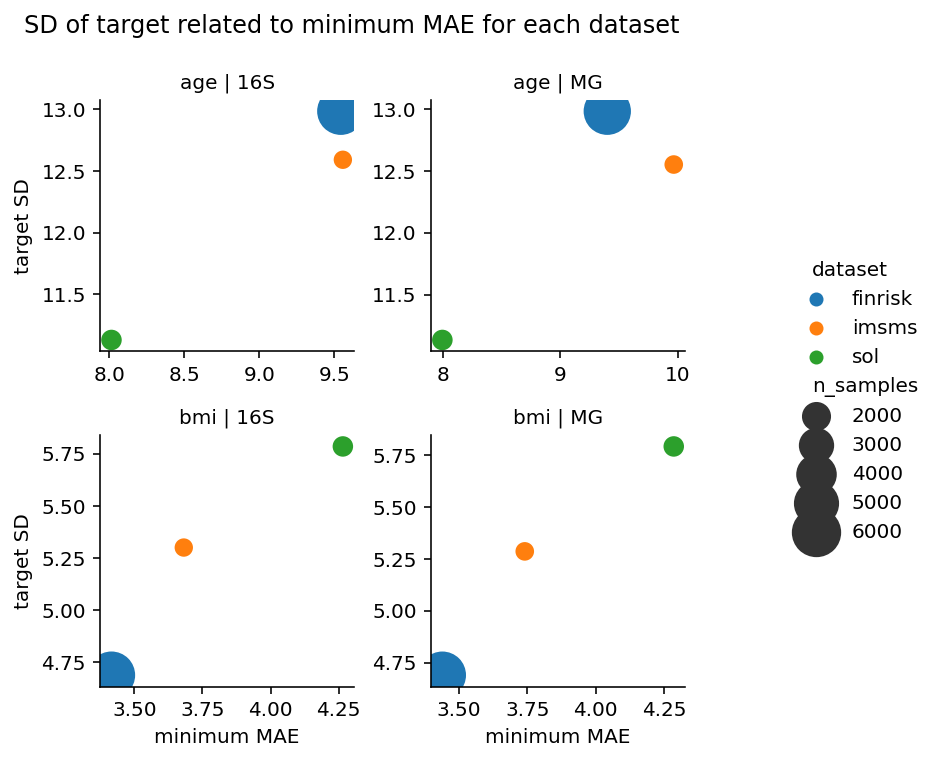

In [16]:
g = sns.relplot(
    data=summary_df[summary_df["metric"]=="min_MAE"],
    row="target",
    col="level",
    x="value",
    y="target_SD",
    hue="dataset", 
    size="n_samples",
    sizes=(100,600),
    facet_kws={'sharey': False, 'sharex': False, 'legend_out': True},
    legend='brief'
)
#g.add_legend()
g.set_axis_labels("minimum MAE", "target SD")
g.fig.set_size_inches(5,5)
g.fig.tight_layout(w_pad=0)
g._legend.set_bbox_to_anchor([1.3, 0.5])
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(wspace=0.3)
plt.suptitle("SD of target related to minimum MAE for each dataset", y=1.05)

Text(0.5, 1.05, 'Relation of MAE to standard deviation of the target')

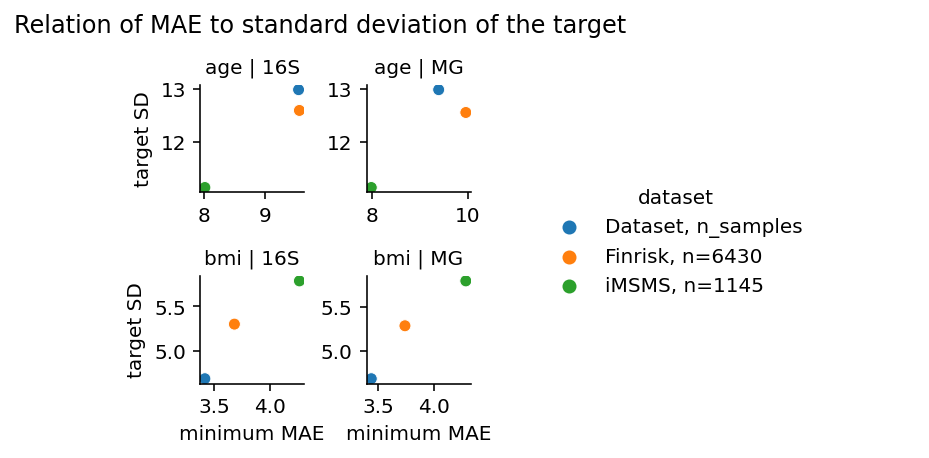

In [17]:
g = sns.relplot(
    data=summary_df[summary_df["metric"]=="min_MAE"],
    row="target",
    col="level",
    x="value",
    y="target_SD",
    hue="dataset",
    sizes=1,
    facet_kws={'sharey': False, 'sharex': False, 'legend_out': True},
    legend='brief'
)
#g.add_legend()
g.set_axis_labels("minimum MAE", "target SD")
g.fig.set_size_inches(3,3)
g.fig.tight_layout(w_pad=0.1)

#plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh', "Aight"])

g._legend.set_bbox_to_anchor([1.9, 0.5])
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(wspace=0.6)

new_labels = ["Dataset, n_samples", 'Finrisk, n=6430', 'iMSMS, n=1145', "SOL, n=1359"]
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.suptitle("Relation of MAE to standard deviation of the target", y=1.05)

In [18]:
dataset_sizes

{'finrisk-16S-age': 6430,
 'finrisk-16S-bmi': 6428,
 'finrisk-MG-age': 6424,
 'finrisk-MG-bmi': 6422,
 'sol-16S-age': 1359,
 'sol-16S-bmi': 1355,
 'sol-MG-age': 1364,
 'sol-MG-bmi': 1359,
 'imsms-16S-age': 1117,
 'imsms-16S-bmi': 1117,
 'imsms-MG-age': 1145,
 'imsms-MG-bmi': 1145}

Text(0.5, 1.05, 'MAE vs Standardized MAE, null model marked by grey line')

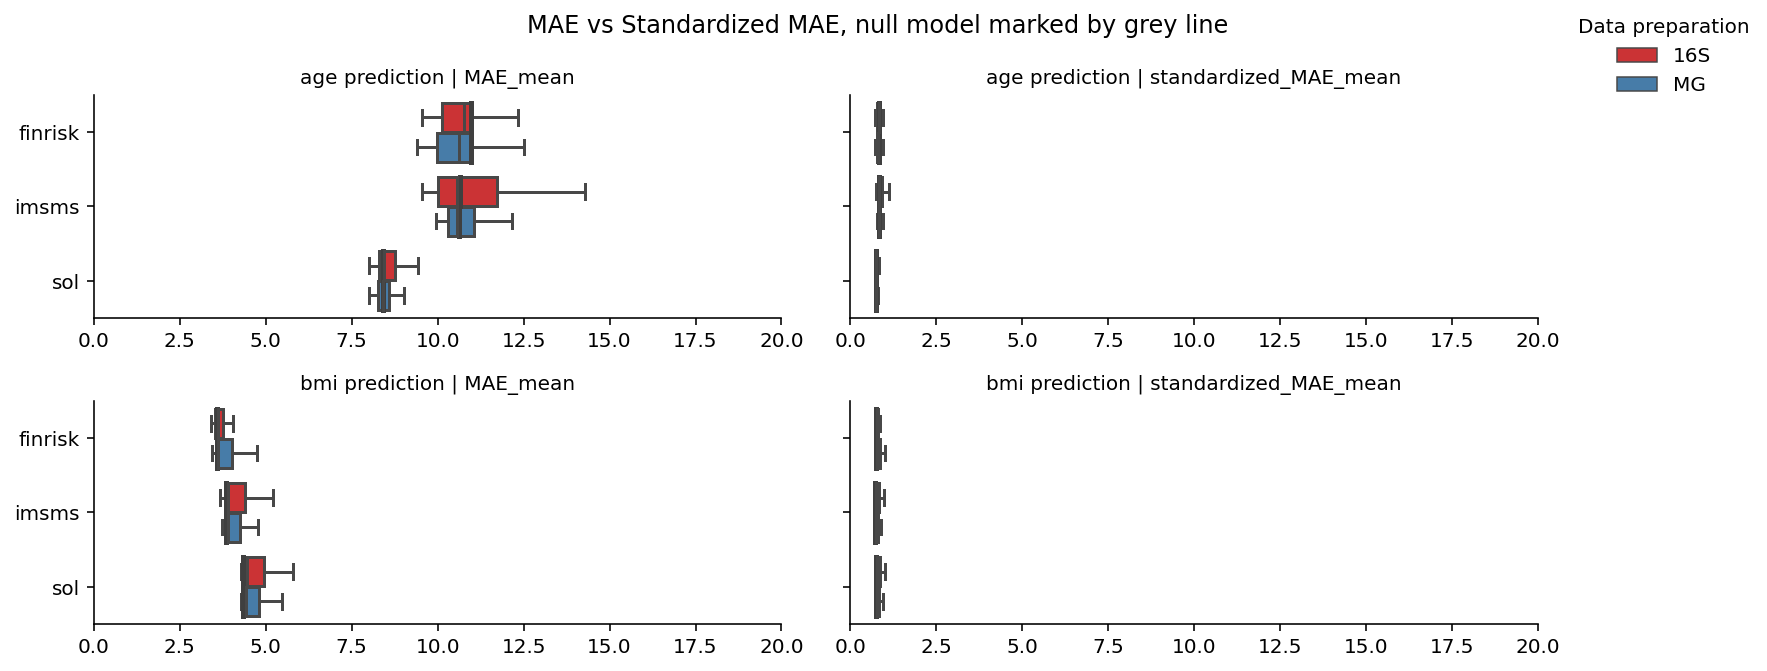

In [19]:
g = sns.FacetGrid(
    melted_df_withnullmodel,
    row="target",
    col="metric",
    sharex=False,
    sharey=True,
    legend_out=True,
    height=2.2, aspect=2.5
)

g.map_dataframe(
    sns.boxplot,
    y = "dataset",
    x = "value",
    hue = "level",
    dodge=True,
    orient='h',
    palette=sns.color_palette("Set1"),
    showfliers=False,
    # decrease point size
)
g.add_legend(title="Data preparation", loc=1)

g.map_dataframe(
    sns.violinplot,
    y = "dataset",
    x = "null_model",
    hue = "level",
    linewidth = 2.5
)

g.set(xlim=(0, 20))
g.set_titles(col_template="{col_name}", row_template="{row_name} prediction")

g.fig.subplots_adjust(wspace=0.1)
plt.suptitle("MAE vs Standardized MAE, null model marked by grey line", y=1.05)

In [20]:
table1 = summary_df.query(
    "target=='age' and metric=='min_standardized_MAE'"
).groupby("dataset").mean()[["n_samples","min_standardized_null","min_null","value"]]
table1['min_standardized_MAE'] = table1["value"]

table2 = summary_df.query(
    "target=='age' and metric=='min_MAE'"
).groupby("dataset").mean()[["n_samples","min_standardized_null","min_null","value"]]
table1['min_MAE'] = table2["value"]

table1[["n_samples",'min_null',"min_standardized_null",'min_MAE',"min_standardized_MAE"]]

,n_samples,min_null,min_standardized_null,min_MAE,min_standardized_MAE
dataset,,,,,
finrisk,6427.0,10.978048,0.845475,9.470834,0.729398
imsms,1131.0,10.629344,0.845474,9.760602,0.776479
sol,1361.5,8.408368,0.755365,8.004002,0.719026


In [21]:
table1 = summary_df.query(
    "level=='16S' and target=='bmi' and metric=='min_standardized_MAE'"
).groupby("dataset").mean()[["n_samples","min_standardized_null","min_null","value"]]
table1['min_standardized_MAE'] = table1["value"]

table2 = summary_df.query(
    "level=='16S' and target=='bmi' and metric=='min_MAE'"
).groupby("dataset").mean()[["n_samples","min_standardized_null","min_null","value"]]
table1['min_MAE'] = table2["value"]

table1[["n_samples",'min_null',"min_standardized_null",'min_MAE',"min_standardized_MAE"]]

,n_samples,min_null,min_standardized_null,min_MAE,min_standardized_MAE
dataset,,,,,
finrisk,6428,3.573353,0.762167,3.416196,0.728723
imsms,1117,3.838911,0.724277,3.681543,0.694847
sol,1355,4.330822,0.748609,4.265232,0.737004


In [22]:
table1 = summary_df.query(
    "level=='MG' and target=='age' and metric=='min_standardized_MAE'"
).groupby("dataset").mean()[["n_samples","min_standardized_null","min_null","value"]]
table1['min_standardized_MAE'] = table1["value"]

table2 = summary_df.query(
    "level=='MG' and target=='age' and metric=='min_MAE'"
).groupby("dataset").mean()[["n_samples","min_standardized_null","min_null","value"]]
table1['min_MAE'] = table2["value"]

table1 = table1[["n_samples",'min_null',"min_standardized_null",'min_MAE',"min_standardized_MAE"]]
table1

,n_samples,min_null,min_standardized_null,min_MAE,min_standardized_MAE
dataset,,,,,
finrisk,6424,10.976350,0.845424,9.398589,0.723904
imsms,1145,10.608734,0.845186,9.964458,0.793930
sol,1364,8.411290,0.755572,7.994432,0.718112


How many years we can improve MAE over null model (not meaningful for comparisons between studies) vs improvement in SD

In [23]:
table1["MAE improvement"] = table1["min_null"] - table1["min_MAE"]
table1["SD-MAE improvement"] = table1["min_standardized_null"] - table1["min_standardized_MAE"]

In [24]:
table1

,n_samples,min_null,min_standardized_null,min_MAE,min_standardized_MAE,MAE improvement,SD-MAE improvement
dataset,,,,,,,
finrisk,6424,10.976350,0.845424,9.398589,0.723904,1.577761,0.121520
imsms,1145,10.608734,0.845186,9.964458,0.793930,0.644276,0.051255
sol,1364,8.411290,0.755572,7.994432,0.718112,0.416858,0.037460


# FIG2
<a id=’FIG2’></a>
We standardized for target and dataset.
We can now compare data type and algorithm.


Which algorithms perform best?
* A) Comparison of ensemble, boosting, and linear algorithms
* B) Performance summary stats/table and recommendations

% of models below the null model


#### What's the worst model, relative to nonsense (null model)
We need to communicate the cardinality of HP sets (roughly complexity), and the % of times worse than null, and the best MAE.

Box plot:
x="num of tunable parameters, categorical/ranked"
y="% of times performing worse than the null"
Do algorithms with most hyperparameters perform worse than null?
Best is whatever has the fewest hyperparameters worse than null.
Annotate min MAE for each algorithm.

#### What's the best model, relative to min MAE or distance from nonsense (null model)
SD-MAE improvement over the null.
Order algorithms by min MAE ranking, or by # hyperparameters, etc.

In [25]:
melted_df_withnullmodel["algorithm_family"] = (
    [algorithm_to_family[a] for a in melted_df_withnullmodel.algorithm]
)
melted_df_withnullmodel

,dataset,level,target,parameters_id,algorithm,metric,value,target_SD_mean,null_model,algorithm_family
0,finrisk,16S,age,1,Lasso,MAE_mean,10.110120,12.985684,10.979747,Linear
1,finrisk,16S,age,1,RidgeRegressor,MAE_mean,22.886260,12.985684,10.979747,Linear
16,finrisk,16S,age,2,Lasso,MAE_mean,71.736632,12.985684,10.979747,Linear
17,finrisk,16S,age,2,RidgeRegressor,MAE_mean,106.576807,12.985684,10.979747,Linear
32,finrisk,16S,age,3,Lasso,MAE_mean,10.153145,12.985684,10.979747,Linear
...,...,...,...,...,...,...,...,...,...,...
133687,sol,MG,bmi,6052,RidgeRegressor,standardized_MAE_mean,5.052347,5.791598,0.747499,Linear
133695,sol,MG,bmi,6053,RidgeRegressor,standardized_MAE_mean,1.615783,5.791598,0.747499,Linear
133703,sol,MG,bmi,6054,RidgeRegressor,standardized_MAE_mean,1.026642,5.791598,0.747499,Linear
133711,sol,MG,bmi,6055,RidgeRegressor,standardized_MAE_mean,1.677390,5.791598,0.747499,Linear


In [26]:
melted_df_withnullmodel["improvement_over_null"] = melted_df_withnullmodel["null_model"] - melted_df_withnullmodel["value"] 

In [27]:
melted_df_withnullmodel

,dataset,level,target,parameters_id,algorithm,metric,value,target_SD_mean,null_model,algorithm_family,improvement_over_null
0,finrisk,16S,age,1,Lasso,MAE_mean,10.110120,12.985684,10.979747,Linear,0.869626
1,finrisk,16S,age,1,RidgeRegressor,MAE_mean,22.886260,12.985684,10.979747,Linear,-11.906513
16,finrisk,16S,age,2,Lasso,MAE_mean,71.736632,12.985684,10.979747,Linear,-60.756885
17,finrisk,16S,age,2,RidgeRegressor,MAE_mean,106.576807,12.985684,10.979747,Linear,-95.597060
32,finrisk,16S,age,3,Lasso,MAE_mean,10.153145,12.985684,10.979747,Linear,0.826601
...,...,...,...,...,...,...,...,...,...,...,...
133687,sol,MG,bmi,6052,RidgeRegressor,standardized_MAE_mean,5.052347,5.791598,0.747499,Linear,-4.304848
133695,sol,MG,bmi,6053,RidgeRegressor,standardized_MAE_mean,1.615783,5.791598,0.747499,Linear,-0.868284
133703,sol,MG,bmi,6054,RidgeRegressor,standardized_MAE_mean,1.026642,5.791598,0.747499,Linear,-0.279143
133711,sol,MG,bmi,6055,RidgeRegressor,standardized_MAE_mean,1.677390,5.791598,0.747499,Linear,-0.929891


In [28]:
melted_df_withnullmodel.query(
    "algorithm=='MLPRegressor' and metric=='standardized_MAE_mean'"
    + " and value>0.06"
)['value'].describe()

count    120.000000
mean       0.890514
std        0.168041
min        0.752995
25%        0.770081
50%        0.832191
75%        0.934620
max        1.418186
Name: value, dtype: float64

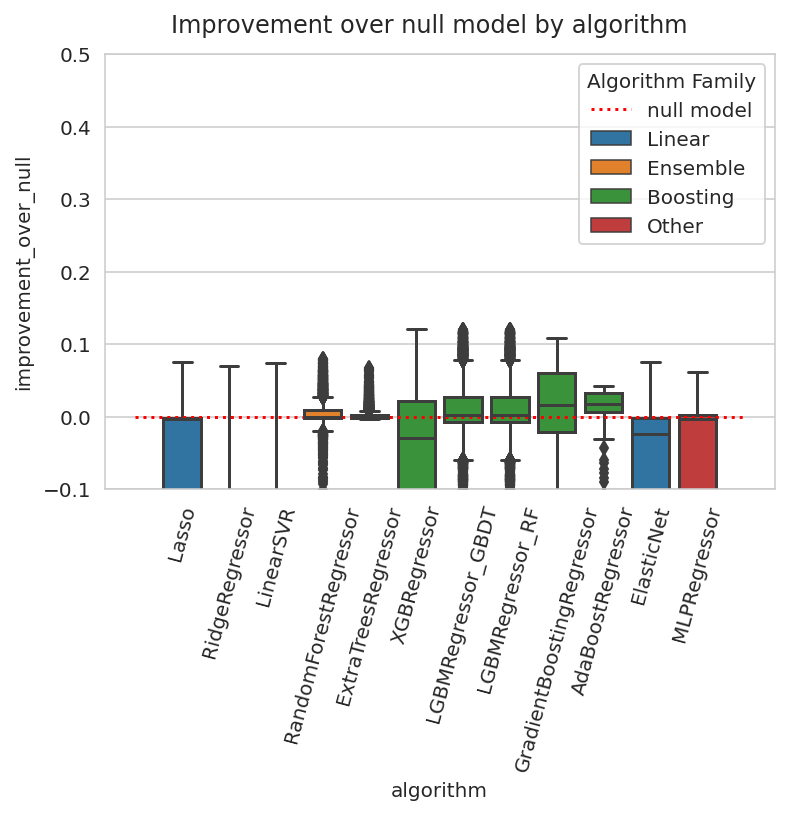

In [29]:
with sns.axes_style("whitegrid"):

    fig, ax = plt.subplots()

    sns.boxplot(
        data=melted_df_withnullmodel.query(
            "metric=='standardized_MAE_mean'"
            + " and value>0.06"
        ),
        x="algorithm", 
        y="improvement_over_null",
        hue="algorithm_family",
        dodge=False,
        showfliers=True,
        ax=ax,
    )
    ax.set_ylim(-.1, 0.5)
    # Plot line at 0 for null model
    x = np.array(range(-1,len(melted_df_withnullmodel["algorithm"].unique())+1))
    ax.plot(x, 0*x, ':r', label='null model')
    ax.legend(title="Algorithm Family", bbox_to_anchor=(1,1))

    # Fix axes labels and title
    ax.set_xticklabels(rotation=75, labels=melted_df_withnullmodel.algorithm.unique())
    plt.suptitle("Improvement over null model by algorithm", y=0.95)

In [30]:
print(
    order_by_counts(melted_df_withnullmodel, "algorithm"),"\n\n",
    order_by_paramspace_cardinality(melted_df_withnullmodel),"\n\n",
    order_by_paramspace_size(melted_df_withnullmodel),
)

(['XGBRegressor', 'ElasticNet', 'LGBMRegressor_RF', 'LGBMRegressor_GBDT', 'RandomForestRegressor', 'RidgeRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'LinearSVR', 'Lasso', 'MLPRegressor', 'AdaBoostRegressor'], [23830, 22120, 21644, 21552, 20660, 9408, 7338, 3816, 2400, 448, 288, 216]) 

 (['XGBRegressor', 'LGBMRegressor_RF', 'LGBMRegressor_GBDT', 'RandomForestRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'RidgeRegressor', 'MLPRegressor', 'LinearSVR', 'ElasticNet', 'AdaBoostRegressor', 'Lasso'], [14, 12, 12, 10, 10, 9, 6, 5, 5, 5, 4, 3]) 

 (['LGBMRegressor_RF', 'LGBMRegressor_GBDT', 'RandomForestRegressor', 'XGBRegressor', 'GradientBoostingRegressor', 'ExtraTreesRegressor', 'MLPRegressor', 'ElasticNet', 'RidgeRegressor', 'LinearSVR', 'Lasso', 'AdaBoostRegressor'], [62208, 62208, 26880, 26244, 20160, 13440, 5580, 2128, 1176, 112, 56, 27])


['XGBRegressor', 'LGBMRegressor_RF', 'LGBMRegressor_GBDT', 'RandomForestRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'RidgeRegressor', 'MLPRegressor', 'LinearSVR', 'ElasticNet', 'AdaBoostRegressor', 'Lasso'] [14, 12, 12, 10, 10, 9, 6, 5, 5, 5, 4, 3]


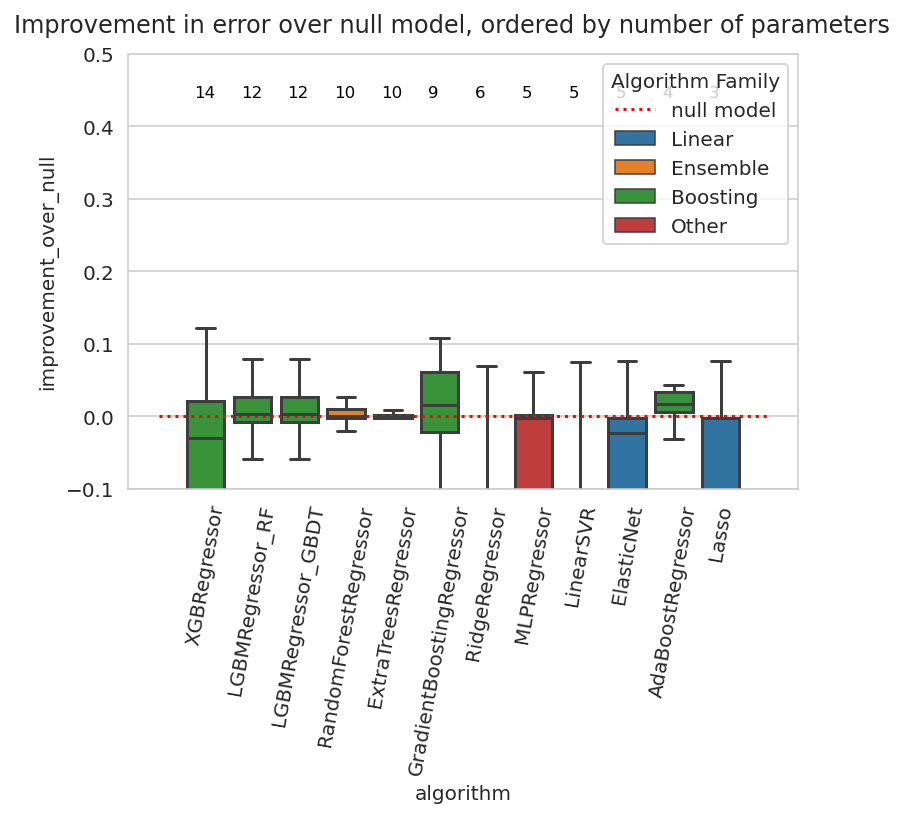

In [31]:
# algorithm_ordering, ordering_values = order_by_counts(melted_df_withnullmodel, "algorithm")
# algorithm_ordering, ordering_values = order_by_paramspace_size(melted_df_withnullmodel)
algorithm_ordering, ordering_values = order_by_paramspace_cardinality(melted_df_withnullmodel)
print(algorithm_ordering, ordering_values)

title_text = "Improvement in error over null model, ordered by number of parameters"
with sns.axes_style("whitegrid"):

    fig, ax = plt.subplots()

    sns.boxplot(
        data=melted_df_withnullmodel.query(
            "metric=='standardized_MAE_mean'"
            + " and value>0.06"
        ),
        x="algorithm",
        order=algorithm_ordering,
        y="improvement_over_null",
        hue="algorithm_family",
        dodge=False,
        showfliers=False,
        ax=ax,
    )
    ax.set_ylim(-.1, 0.5)
    # Plot line at 0 for null model
    x = np.array(range(-1,len(algorithm_ordering)+1))
    ax.plot(x, 0*x, ':r', label='null model')
    ax.legend(title="Algorithm Family", bbox_to_anchor=(1,1))
    
    # annotate lines?
    for line in range(0,len(algorithm_ordering)):
         ax.text(
             x=line-.25, 
             y=0.44, 
             s=str(ordering_values[line]), 
             horizontalalignment='left', 
             size='small', 
             color='black',
             rotation=0,
             #weight='semibold'
         )

    # Fix axes labels and title
    ax.set_xticklabels(rotation=80, labels=algorithm_ordering)
    plt.suptitle(title_text, y=0.95)

Text(0.5, 0.95, 'Improvement over null model by algorithm')

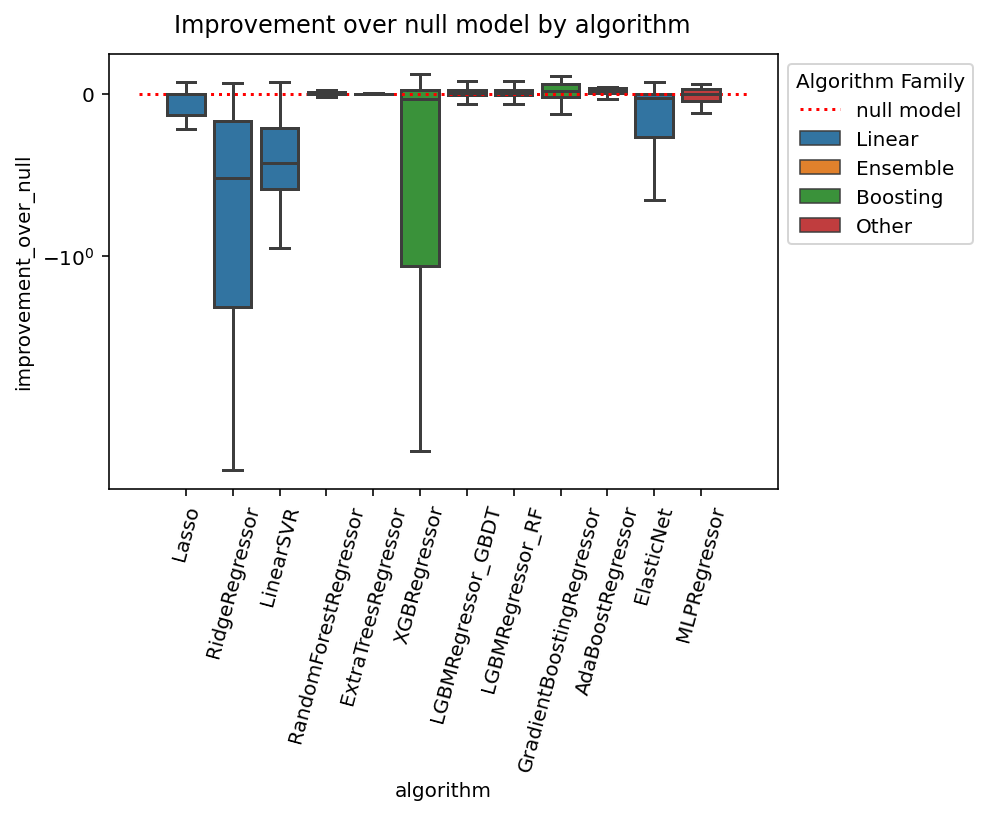

In [32]:
ax = sns.boxplot(
    data=melted_df_withnullmodel.query(
        "metric=='standardized_MAE_mean'"
        #+ " and value>0.06"
    ),
    x="algorithm", 
    y="improvement_over_null",
    hue="algorithm_family",
    dodge=False,
    showfliers=False,
)

# Plot line at 0 for null model
x = np.array(range(-1,len(melted_df_withnullmodel["algorithm"].unique())+1))
ax.plot(x, 0*x, ':r', label='null model')
ax.legend(title="Algorithm Family", bbox_to_anchor=(1,1))
ax.set_yscale("symlog")

# Fix axes labels and title
ax.set_xticklabels(rotation=75, labels=melted_df_withnullmodel.algorithm.unique())
plt.suptitle("Improvement over null model by algorithm", y=0.95)

['XGBRegressor', 'LGBMRegressor_RF', 'LGBMRegressor_GBDT', 'RandomForestRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'RidgeRegressor', 'MLPRegressor', 'LinearSVR', 'ElasticNet', 'AdaBoostRegressor', 'Lasso'] [14, 12, 12, 10, 10, 9, 6, 5, 5, 5, 4, 3]


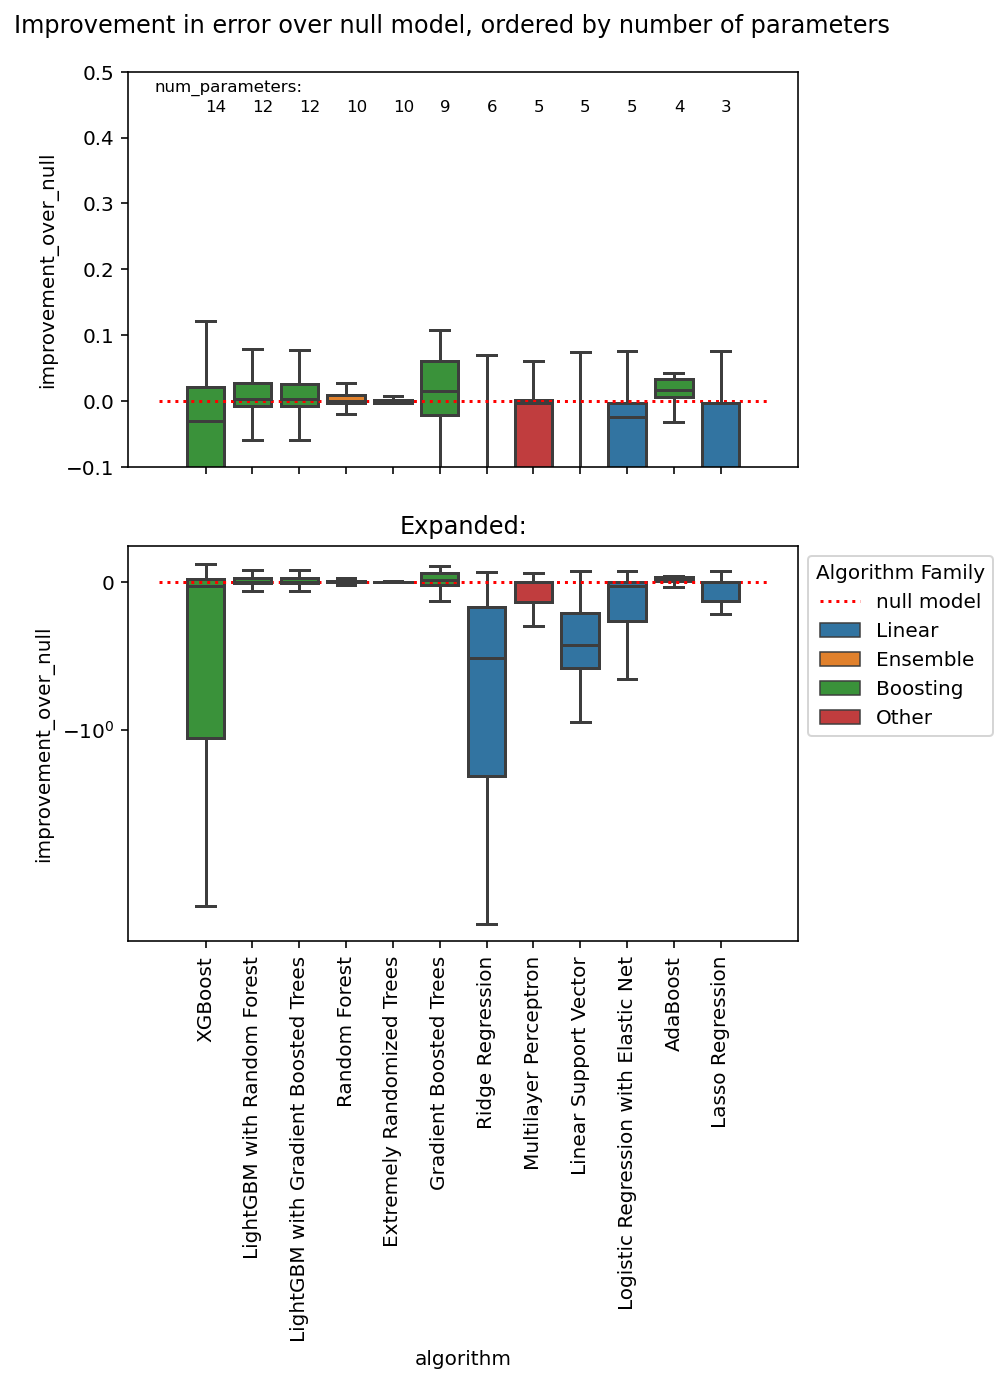

In [33]:
fig, axes = plt.subplots(2,1, figsize=(6,8))

ax = axes[0]
# algorithm_ordering, ordering_values = order_by_counts(melted_df_withnullmodel, "algorithm")
# algorithm_ordering, ordering_values = order_by_paramspace_size(melted_df_withnullmodel)
algorithm_ordering, ordering_values = order_by_paramspace_cardinality(melted_df_withnullmodel)
print(algorithm_ordering, ordering_values)

title_text = "Improvement in error over null model, ordered by number of parameters"

sns.boxplot(
    data=melted_df_withnullmodel.query(
        "metric=='standardized_MAE_mean'"
        + " and value>0.06"
    ),
    x="algorithm",
    order=algorithm_ordering,
    y="improvement_over_null",
    hue="algorithm_family",
    dodge=False,
    showfliers=False,
    ax=ax,
)
ax.set_ylim(-.1, 0.5)

# Plot line at 0 for null model
x = np.array(range(-1,len(algorithm_ordering)+1))
ax.plot(x, 0*x, ':r', label='null model')
# ax.legend(title="Algorithm Family", bbox_to_anchor=(1,1))
# ax.set_title("Full space")
ax.legend_.remove()

# annotate lines?
for line in range(0,len(algorithm_ordering)):
     ax.text(
         x=line, 
         y=0.44, 
         s=str(ordering_values[line]), 
         horizontalalignment='left', 
         size='small', 
         color='black',
         rotation=0
         #weight='semibold'
     )
ax.text(
         x=0.5, 
         y=0.47, 
         s="num_parameters:", 
         horizontalalignment='center', 
         size='small', 
         color='black',
         rotation=0
         #weight='semibold'
     )
ax.set_xticklabels([])
ax.set_xlabel(None)



######################################################
ax = axes[1]
#sns.boxenplot(
sns.boxplot(
    data=melted_df_withnullmodel.query(
        "metric=='standardized_MAE_mean'"
        + " and value>0.06"
    ),
    x="algorithm",
    order=algorithm_ordering,
    y="improvement_over_null",
    hue="algorithm_family",
    dodge=False,
    showfliers=False,
    ax=ax
)

# Plot line at 0 for null model
x = np.array(range(-1,len(melted_df_withnullmodel["algorithm"].unique())+1))
ax.plot(x, 0*x, ':r', label='null model')
ax.legend(title="Algorithm Family", bbox_to_anchor=(1,1))


######################################################

# Fix axes labels and title
ax.set_title("Expanded:")
ax.set_yscale("symlog")

labels = [readablename[a] for a in algorithm_ordering]

# Fix axes labels and title
ax.set_xticklabels(rotation=90, labels=labels)
plt.suptitle(title_text, y=0.93)
fig.subplots_adjust(hspace=0.2)

['XGBRegressor', 'LGBMRegressor_RF', 'LGBMRegressor_GBDT', 'RandomForestRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'RidgeRegressor', 'MLPRegressor', 'LinearSVR', 'ElasticNet', 'AdaBoostRegressor', 'Lasso'] [14, 12, 12, 10, 10, 9, 6, 5, 5, 5, 4, 3]


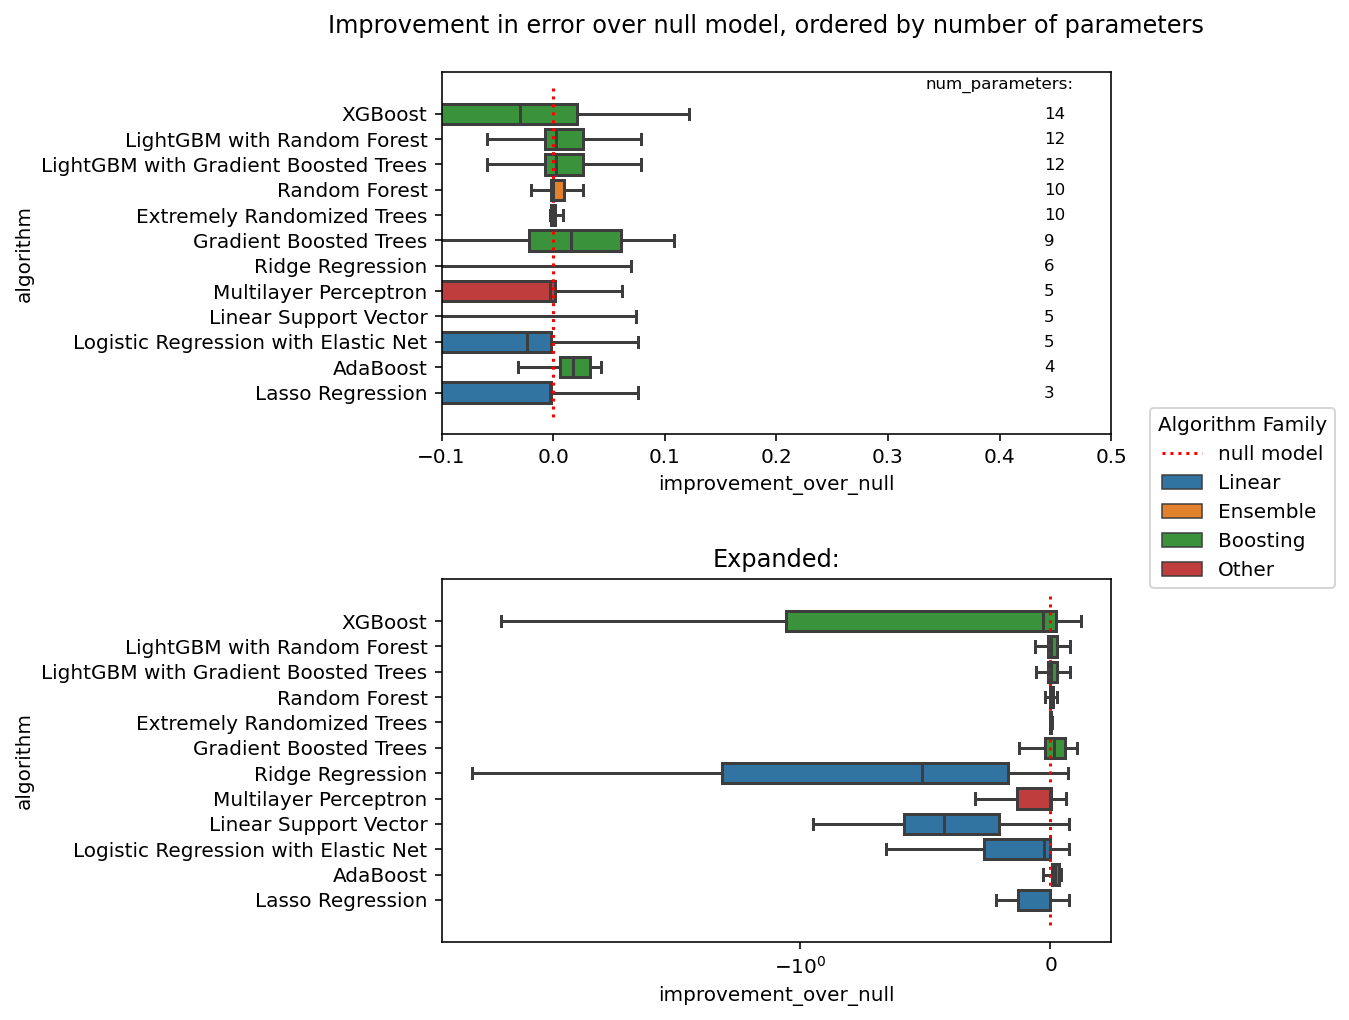

In [34]:
# Make Horizontal

fig, axes = plt.subplots(2,1, figsize=(6,8))

ax = axes[0]
# algorithm_ordering, ordering_values = order_by_counts(melted_df_withnullmodel, "algorithm")
# algorithm_ordering, ordering_values = order_by_paramspace_size(melted_df_withnullmodel)
algorithm_ordering, ordering_values = order_by_paramspace_cardinality(melted_df_withnullmodel)
print(algorithm_ordering, ordering_values)

title_text = "Improvement in error over null model, ordered by number of parameters"

sns.boxplot(
    data=melted_df_withnullmodel.query(
        "metric=='standardized_MAE_mean'"
        + " and value>0.06"
    ),
    y="algorithm",
    order=algorithm_ordering,
    x="improvement_over_null",
    hue="algorithm_family",
    dodge=False,
    showfliers=False,
    ax=ax,
)
ax.set_xlim(-.1, 0.5)

# Plot line at 0 for null model
x = np.array(range(-1,len(algorithm_ordering)+1))
ax.plot(0*x, x, ':r', label='null model')
# ax.legend(title="Algorithm Family", bbox_to_anchor=(1,1))
# ax.set_title("Full space")
ax.legend_.remove()

# annotate lines?
for line in range(0,len(algorithm_ordering)):
     ax.text(
         y=line+.2, 
         x=0.44, 
         s=str(ordering_values[line]), 
         horizontalalignment='left', 
         size='small', 
         color='black',
         rotation=0
         #weight='semibold'
     )
ax.text(
    y=-1.0,
    x=.4,
    s="num_parameters:", 
    horizontalalignment='center', 
    size='small', 
    color='black',
    rotation=0
    #weight='semibold'
)

labels = [readablename[a] for a in algorithm_ordering]

# Fix axes labels and title
ax.set_yticklabels(rotation=0, labels=labels)
#ax.set_xlabel(None)

######################################################
ax = axes[1]
sns.boxplot(
    data=melted_df_withnullmodel.query(
        "metric=='standardized_MAE_mean'"
        + " and value>0.06"
    ),
    y="algorithm",
    order=algorithm_ordering,
    x="improvement_over_null",
    hue="algorithm_family",
    dodge=False,
    showfliers=False,
    ax=ax
)

# Plot line at 0 for null model
x = np.array(range(-1,len(melted_df_withnullmodel["algorithm"].unique())+1))
ax.plot(0*x, x, ':r', label='null model')
ax.legend(title="Algorithm Family", bbox_to_anchor=(1.35,1.5))
ax.set_xscale("symlog")

######################################################

# Fix axes labels and title
ax.set_title("Expanded:")


# Fix axes labels and title
ax.set_yticklabels(rotation=0, labels=labels)
plt.suptitle(title_text, y=0.93)
fig.subplots_adjust(hspace=0.4)

IndexError: list index out of range

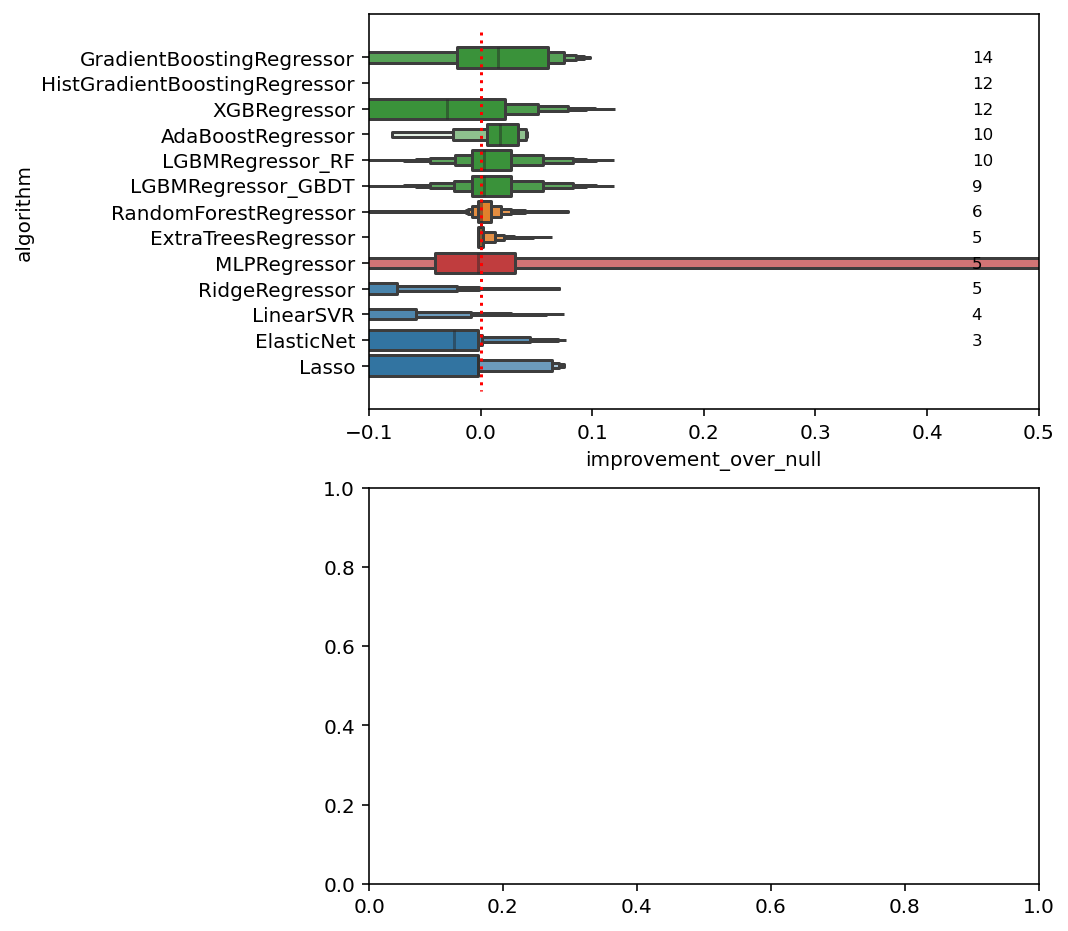

In [35]:
# Make Horizontal

fig, axes = plt.subplots(2,1, figsize=(6,8))

ax = axes[0]
algorithm_ordering = [
    'GradientBoostingRegressor', 
    'HistGradientBoostingRegressor', 
    'XGBRegressor',
    'AdaBoostRegressor', 
    'LGBMRegressor_RF', 
    'LGBMRegressor_GBDT', 
    'RandomForestRegressor', 
    'ExtraTreesRegressor', 
    'MLPRegressor', 
    'RidgeRegressor', 
    'LinearSVR', 
    'ElasticNet', 
    'Lasso'
]

title_text = "Improvement in error over null model, ordered by number of parameters"

sns.boxenplot(
    data=melted_df_withnullmodel.query(
        "metric=='standardized_MAE_mean'"
        #+ " and value>0.06"
    ),
    y="algorithm",
    order=algorithm_ordering,
    x="improvement_over_null",
    hue="algorithm_family",
    dodge=False,
    showfliers=False,
    ax=ax,
)
ax.set_xlim(-.1, 0.5)

# Plot line at 0 for null model
x = np.array(range(-1,len(algorithm_ordering)+1))
ax.plot(0*x, x, ':r', label='null model')
# ax.legend(title="Algorithm Family", bbox_to_anchor=(1,1))
# ax.set_title("Full space")
ax.legend_.remove()

# annotate lines?
for line in range(0,len(algorithm_ordering)):
     ax.text(
         y=line+.2, 
         x=0.44, 
         s=str(ordering_values[line]), 
         horizontalalignment='left', 
         size='small', 
         color='black',
         rotation=0
         #weight='semibold'
     )
ax.text(
    y=-1.0,
    x=.4,
    s="num_parameters:", 
    horizontalalignment='center', 
    size='small', 
    color='black',
    rotation=0
    #weight='semibold'
)

labels = [readablename[a] for a in algorithm_ordering]

# Fix axes labels and title
ax.set_yticklabels(rotation=0, labels=labels)
#ax.set_xlabel(None)

######################################################
ax = axes[1]
sns.boxplot(
    data=melted_df_withnullmodel.query(
        "metric=='standardized_MAE_mean'"
        #+ " and value>0.06"
    ),
    y="algorithm",
    order=algorithm_ordering,
    x="improvement_over_null",
    hue="algorithm_family",
    dodge=False,
    showfliers=False,
    ax=ax
)

# Plot line at 0 for null model
x = np.array(range(-1,len(melted_df_withnullmodel["algorithm"].unique())+1))
ax.plot(0*x, x, ':r', label='null model')
ax.legend(title="Algorithm Family", bbox_to_anchor=(1.35,1.5))
ax.set_xscale("symlog")

######################################################

# Fix axes labels and title
ax.set_title("Expanded:")


# Fix axes labels and title
ax.set_yticklabels(rotation=0, labels=labels)
plt.suptitle(title_text, y=0.93)
fig.subplots_adjust(hspace=0.4)

In [ ]:
melted_df_withnullmodel.query(
    "algorithm=='MLPRegressor' and metric=='standardized_MAE_mean' and value>0.06"
)["value"].sort_values()


In [ ]:
melted_df_withnullmodel

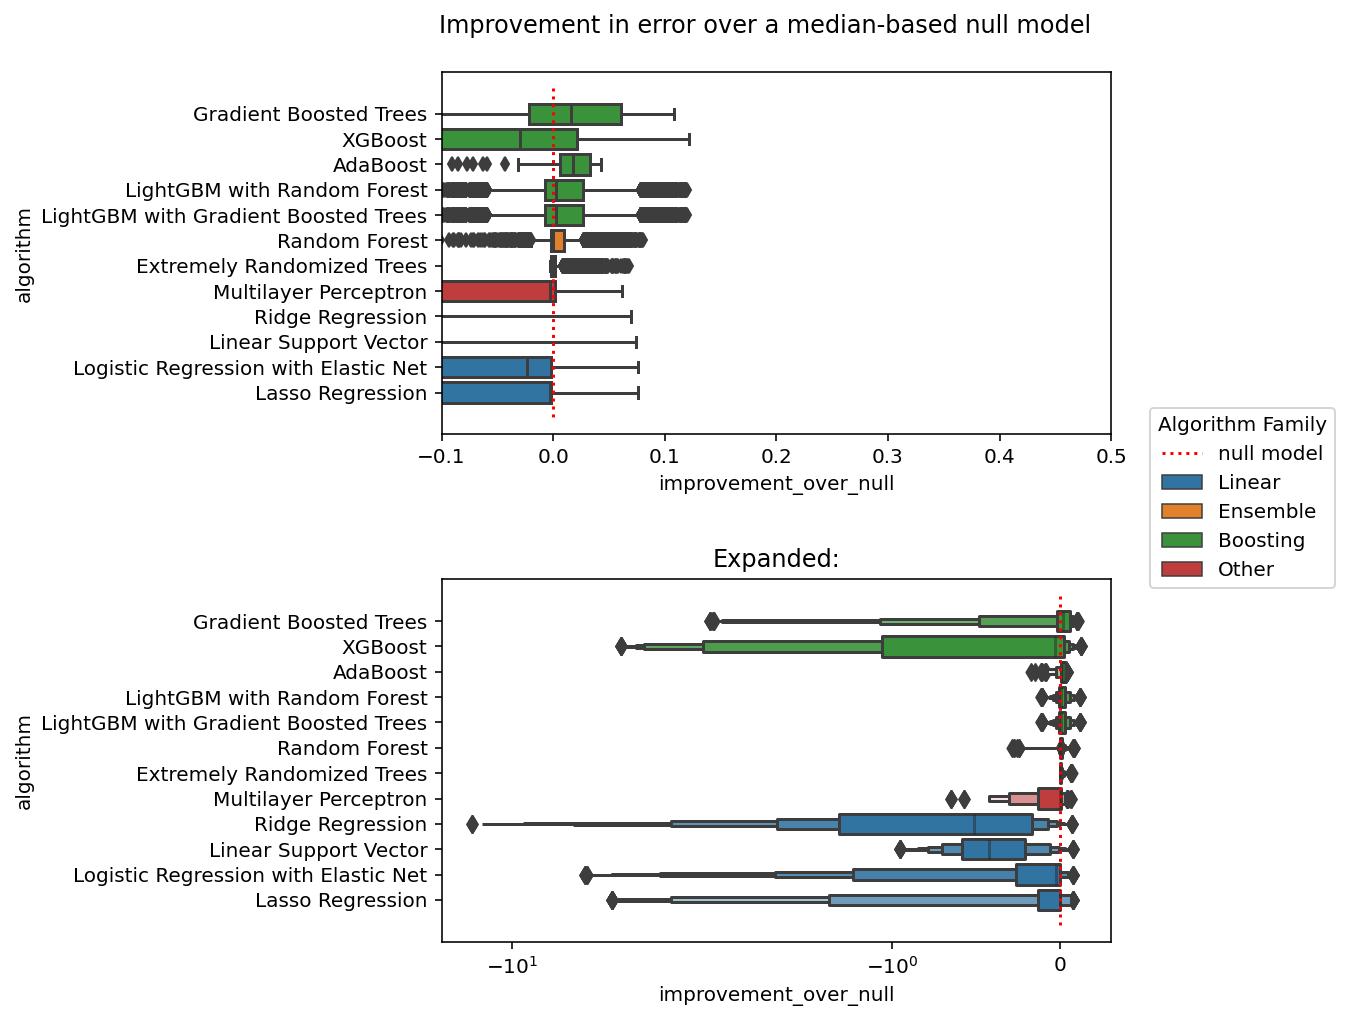

In [41]:
# Make Horizontal

fig, axes = plt.subplots(2,1, figsize=(6,8))

ax = axes[0]
algorithm_ordering = [
    'GradientBoostingRegressor', 
#    'HistGradientBoostingRegressor', 
    'XGBRegressor',
    'AdaBoostRegressor', 
    'LGBMRegressor_RF', 
    'LGBMRegressor_GBDT', 
    'RandomForestRegressor', 
    'ExtraTreesRegressor', 
    'MLPRegressor', 
    'RidgeRegressor', 
    'LinearSVR', 
    'ElasticNet', 
    'Lasso'
]
data_subset = melted_df_withnullmodel.query(
    "metric=='standardized_MAE_mean'"
    # Filter extreme outliers
    # accept error > 1 year (stdev is 11-14 years,  null model error is 8-11 yrs)
    + " and value>.06" 
)
title_text = "Improvement in error over a median-based null model"

sns.boxplot(
    data=data_subset,
    y="algorithm",
    order=algorithm_ordering,
    x="improvement_over_null",
    hue="algorithm_family",
    dodge=False,
    showfliers=True,
    ax=ax,
)
ax.set_xlim(-.1, 0.5)

# Plot line at 0 for null model
x = np.array(range(-1,len(algorithm_ordering)+1))
ax.plot(0*x, x, ':r', label='null model')
# ax.legend(title="Algorithm Family", bbox_to_anchor=(1,1))
# ax.set_title("Full space")
ax.legend_.remove()

labels = [readablename[a] for a in algorithm_ordering]

# Fix axes labels and title
ax.set_yticklabels(rotation=0, labels=labels)
#ax.set_xlabel(None)

######################################################
ax = axes[1]
sns.boxenplot(
    data=data_subset,
    y="algorithm",
    order=algorithm_ordering,
    x="improvement_over_null",
    hue="algorithm_family",
    dodge=False,
    showfliers=True,
    ax=ax
)

# Plot line at 0 for null model
x = np.array(range(-1,len(melted_df_withnullmodel["algorithm"].unique())+1))
ax.plot(0*x, x, ':r', label='null model')
ax.legend(title="Algorithm Family", bbox_to_anchor=(1.35,1.5))
ax.set_xscale("symlog")

######################################################

# Fix axes labels and title
ax.set_title("Expanded:")


# Fix axes labels and title
ax.set_yticklabels(rotation=0, labels=labels)
plt.suptitle(title_text, y=0.93)
fig.subplots_adjust(hspace=0.4)